In [1]:
import json
import os
import numpy as np
import requests
import pandas as pd
from bs4 import BeautifulSoup
import re
from docx import Document
from docx.shared import Pt
import pickle
import os
from tqdm import tqdm
import time
from langdetect import detect
import matplotlib.pyplot as plt
import collections
from IPython.display import display

import spacy.cli
from spacy.language import Language
import math

from IPython.display import display
import nltk

from transformers import BertTokenizer
import seaborn as sns
from tabulate import tabulate
import prettytable
from prettytable import PrettyTable
from textwrap import fill
from deepdiff import DeepDiff
from tqdm import tqdm
from itertools import chain
import random
from collections import Counter

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
def get_mislassified_and_correct_predictions(test, pred):
    
    """
    Cerco le differenze fra le predizioni e le labels originali, facendo una DeepDiff fra il dizionario delle 
    predizioni e il dizionario delle label vere. Ecco quello che si ottiene
    
    Esempio:
    prova test:  {345: 1, 123: 0}
    prova pred:  {345: 1, 123: 1}

    diff_labels:  {'root[123]': {'new_value': 1, 'old_value': 0}}
    """
    
    # ottengo gli eventi classificati in modo errato
    misclassified_events = DeepDiff(test, pred)['values_changed']
    
    # prendo le chiavi degli eventi classificati in modo errato
    keys_misclassified_events = set(int(k.replace('root[', '').replace(']', '')) for k in misclassified_events)
    
    # e faccio la differenza fra tutti gli eventi classificati e gli eventi classificati male, 
    # perchè voglio ottenere gli eventi classificati correttamente 
    set_classified_events = set(pred)
    
    keys_correct_events = set_classified_events - keys_misclassified_events
    
    diz_correct_events = {}
    
    for k in keys_correct_events:
        diz_correct_events[k] = pred[k]
        
    misclassified_events = {int(k.replace('root[', '').replace(']', '')):v for k,v in misclassified_events.items()}
        
    return misclassified_events, diz_correct_events, keys_misclassified_events, keys_correct_events

In [3]:
def get_diff_classifications(lista_df_test, lista_dist, lista_diz_pred, lista_clf_epoch):
    
    diz_global = {}

    for df_test, dist, diz_pred in tqdm(zip(lista_df_test, lista_dist, lista_diz_pred)):
        
        diz_global[dist] = {}

        test = df_test.set_index('Id')[['Class']].astype('int64').to_dict(orient='dict')['Class']
    
        for clf_epoch in lista_clf_epoch:
            
            diz_global[dist][clf_epoch] = {}

            pred = {k:int(val) for k,val in diz_pred['{}'.format(dist)][clf_epoch]['ids_preds'].items()}
        
            misclassified_events, diz_correct_events, \
                keys_misclassified_events, keys_correct_events = get_mislassified_and_correct_predictions(test, pred)
            
            diz_global[dist][clf_epoch]['misclassified_events'] = misclassified_events
            diz_global[dist][clf_epoch]['diz_correct_events'] = diz_correct_events
            diz_global[dist][clf_epoch]['keys_misclassified_events'] = keys_misclassified_events
            diz_global[dist][clf_epoch]['keys_correct_events'] = keys_correct_events
            
    return diz_global

In [4]:
def save_dataframe(file_name, dataframe_to_save):
    
    try:
        dataframe_to_save.to_csv(path_salvataggio+file_name+".csv", index = False, sep = "\t", encoding='utf-8')
        print("File salvato correttamente")
        
    except:
        print("Errore nel salvataggio")
    
    return 

**Vogliamo trovare eventi classificati correttamente o meno sia dai singoli classificatori, sia da entrambi i classificatori, in modo da mostrare le rispettive probabilità di classificazione e capire la sicurezza del modello nel predire un certo risultato.**

In [4]:
path_pickle = "../pickle/"

In [5]:
path_dataset = "../dataset/train_test/"

In [6]:
path_salvataggio = "../dataset/confronti_classificazione_eventi/"

In [7]:
path_diz_res = "../eventi_classificati_bene_male/"

In [8]:
path_images = "../plots/"
path_images_tit_ridotti = "../plots_titoli_ridotti/"

# Dataset di test originali

In [25]:
df_dist_5_test = pd.read_csv(path_dataset + "df_dist_5_with_ids_ridotto_test.csv", sep="\t")
df_dist_10_test = pd.read_csv(path_dataset + "df_dist_10_with_ids_ridotto_test.csv", sep="\t")
df_dist_20_test = pd.read_csv(path_dataset + "df_dist_20_with_ids_ridotto_test.csv", sep="\t")
df_dist_30_test = pd.read_csv(path_dataset + "df_dist_30_with_ids_ridotto_test.csv", sep="\t")
#df_random_speech_test = pd.read_csv(path_dataset + "df_random_speech_with_ids_ridotto_test.csv", sep="\t")

In [11]:
df_dist_5_test

Id                                         Sentence_1  \
0      29327  Goldman Prize, che è un po' il Nobel dell'ambi...   
1      67142  Nonostante sia stato terminato come progetto, ...   
2       9675                             Non l'aveva mai visto.   
3      16322  E in quel momento senza nessun dubbio abbiamo ...   
4      71604  I giornalisti di ProPublica, una testata inves...   
...      ...                                                ...   
2395  171348  Dietro però c'è stato un piano e c'è anche un ...   
2396  180390                                    Succede spesso.   
2397  195372  Perché dovremmo impegnarci in questa combinazi...   
2398   84571  Al contrario, in inverno, si vede la Via Latte...   
2399   16522  Pensate che alla fine degli anni Novanta si pe...   

                                             Sentence_2  Class  
0     Se voi passeggiate per Cerro de Pasco, o per q...      1  
1     In più, si prestano benissimo questi moduli ad...      1  
2     Se l'era immaginato tante volte ma anche adess...      0  
3     Vedete, in quel momento ho capito una cosa mol...      0  
4     Ora, come non è vero che i miei capelli rossi ...      0  
...                                                 ...    ...  
2395  Tra parentesi, la settimana scorsa vari sondag...      1  
2396  Se sanguino, ovviamente la medicazione la fa l...      0  
2397  Perché impegnarci in questa combinazione di sk...      1  
2398  Presenta meno colori, meno forme e soprattutto...      0  
2399  In realtà si è capito che eravamo solo all'ini...      0  

[2400 rows x 4 columns]

# Risultati classificazione SVM

In [26]:
dist_5_svm = open(path_pickle + "/" + "diz_classifiers_bert_svm_df_dist_5.pickle", "rb")
dist_10_svm = open(path_pickle + "/" + "diz_classifiers_bert_svm_df_dist_10.pickle", "rb")
dist_20_svm = open(path_pickle + "/" + "diz_classifiers_bert_svm_df_dist_20.pickle", "rb")
dist_30_svm = open(path_pickle + "/" + "diz_classifiers_bert_svm_df_dist_30.pickle", "rb")
#dist_random_speech_svm = open(path_pickle + "/" + "diz_classifiers_bert_svm_df_random_speech.pickle", "rb")

diz_dist_5_svm = pickle.load(dist_5_svm)
diz_dist_10_svm = pickle.load(dist_10_svm)
diz_dist_20_svm = pickle.load(dist_20_svm)
diz_dist_30_svm = pickle.load(dist_30_svm)
#diz_random_speech_svm = pickle.load(dist_random_speech_svm)

# Risultati classificazione BERT fine-tunato

In [27]:
dist_5_bf = open(path_pickle + "/" + "df_dist_5_diz_bert_finetuning.pickle", "rb")
dist_10_bf = open(path_pickle + "/" + "df_dist_10_diz_bert_finetuning.pickle", "rb")
dist_20_bf = open(path_pickle + "/" + "df_dist_20_diz_bert_finetuning.pickle", "rb")
dist_30_bf = open(path_pickle + "/" + "df_dist_30_diz_bert_finetuning.pickle", "rb")
#random_speech_bf = open(path_pickle + "/" + "df_random_speech_diz_bert_finetuning.pickle", "rb")

diz_dist_5_bf = pickle.load(dist_5_bf)
diz_dist_10_bf = pickle.load(dist_10_bf)
diz_dist_20_bf = pickle.load(dist_20_bf)
diz_dist_30_bf = pickle.load(dist_30_bf)
#diz_random_speech_bf = pickle.load(random_speech_bf)

In [28]:
risorsa = "TEDx"

In [29]:
lista_clf = ["clf_{}".format(i) for i in range(1,13)]
print(lista_clf)
print()

lista_epoche = ['Epoch{}'.format(i) for i in range (0,5)]
print(lista_epoche)
print()

lista_dist = ['df_dist_5', 'df_dist_10', 'df_dist_20', 'df_dist_30']
print(lista_dist)

lista_df_test = [df_dist_5_test, df_dist_10_test, df_dist_20_test, df_dist_30_test]

lista_diz_pred_svm = [diz_dist_5_svm, diz_dist_10_svm, diz_dist_20_svm, diz_dist_30_svm]

lista_diz_pred_bert_finetunato = [diz_dist_5_bf, diz_dist_10_bf, diz_dist_20_bf, diz_dist_30_bf]

['clf_1', 'clf_2', 'clf_3', 'clf_4', 'clf_5', 'clf_6', 'clf_7', 'clf_8', 'clf_9', 'clf_10', 'clf_11', 'clf_12']

['Epoch0', 'Epoch1', 'Epoch2', 'Epoch3', 'Epoch4']

['df_dist_5', 'df_dist_10', 'df_dist_20', 'df_dist_30']


### Prendiamo, per ogni distanza, per ogni classificatore o epoca, tutti gli eventi classificati correttamente o in modo errato

In [21]:
diz_global_svm = get_diff_classifications(lista_df_test, lista_dist, lista_diz_pred_svm, lista_clf)

4it [00:04,  1.07s/it]


In [22]:
diz_global_bert = get_diff_classifications(lista_df_test, lista_dist, lista_diz_pred_bert_finetunato, lista_epoche)

4it [00:01,  2.27it/s]


In [23]:
for dist in diz_global_svm:
    print("{}: {} clf".format(dist, len(diz_global_svm[dist])))

df_dist_5: 12 clf
df_dist_10: 12 clf
df_dist_20: 12 clf
df_dist_30: 12 clf


In [24]:
for dist in diz_global_bert:
    print("{}: {} epochs".format(dist, len(diz_global_bert[dist])))

df_dist_5: 5 epochs
df_dist_10: 5 epochs
df_dist_20: 5 epochs
df_dist_30: 5 epochs


In [25]:
diz_global_svm['df_dist_5']['clf_1'].keys()

dict_keys(['misclassified_events', 'diz_correct_events', 'keys_misclassified_events', 'keys_correct_events'])

In [26]:
len(diz_global_svm['df_dist_5']['clf_1']['keys_misclassified_events']) + \
len(diz_global_svm['df_dist_5']['clf_1']['keys_correct_events'])

2400

In [27]:
diz_global_svm

{'df_dist_5': {'clf_1': {'misclassified_events': {9675: {'new_value': 1,
     'old_value': 0},
    155256: {'new_value': 1, 'old_value': 0},
    183537: {'new_value': 0, 'old_value': 1},
    83194: {'new_value': 1, 'old_value': 0},
    34947: {'new_value': 0, 'old_value': 1},
    77280: {'new_value': 0, 'old_value': 1},
    39320: {'new_value': 1, 'old_value': 0},
    37936: {'new_value': 1, 'old_value': 0},
    96716: {'new_value': 1, 'old_value': 0},
    84799: {'new_value': 1, 'old_value': 0},
    3226: {'new_value': 1, 'old_value': 0},
    68640: {'new_value': 0, 'old_value': 1},
    15143: {'new_value': 0, 'old_value': 1},
    77696: {'new_value': 0, 'old_value': 1},
    35473: {'new_value': 0, 'old_value': 1},
    137203: {'new_value': 1, 'old_value': 0},
    56295: {'new_value': 0, 'old_value': 1},
    33031: {'new_value': 1, 'old_value': 0},
    74576: {'new_value': 1, 'old_value': 0},
    63912: {'new_value': 0, 'old_value': 1},
    142465: {'new_value': 0, 'old_value': 1},
  

In [28]:
diz_global_svm['df_dist_5']['clf_1'].keys()

dict_keys(['misclassified_events', 'diz_correct_events', 'keys_misclassified_events', 'keys_correct_events'])

In [29]:
diz_global_svm['df_dist_5']['clf_12'].keys()

dict_keys(['misclassified_events', 'diz_correct_events', 'keys_misclassified_events', 'keys_correct_events'])

### Prendiamo gli insiemi di eventi classificati bene o male di tutti i classificatori o di tutte le epoche, col fine di fare l'intersezione e individuare eventi classificati bene o male da tutti i modelli (CONFRONTI INTERNI)

In [30]:
def get_total_set_classifications(lista_dist, lista_clf_epoch, diz_global):
    
    diz_total_set_classifications = {}

    for dist in lista_dist:
        
        diz_total_set_classifications[dist] = {}
        
        lista_set_misclassified = []
        lista_set_correct = []
        
        for clf_epoch in lista_clf_epoch:
            lista_set_misclassified.append(diz_global[dist][clf_epoch]['keys_misclassified_events'])
            lista_set_correct.append(diz_global[dist][clf_epoch]['keys_correct_events'])
            
        diz_total_set_classifications[dist]['lista_set_misclassified'] = lista_set_misclassified
        diz_total_set_classifications[dist]['lista_set_correct'] = lista_set_correct
        
    return diz_total_set_classifications

In [31]:
diz_total_set_classifications_svm = get_total_set_classifications(lista_dist, lista_clf, diz_global_svm)

In [32]:
diz_total_set_classifications_bert = get_total_set_classifications(lista_dist, lista_epoche, diz_global_bert)

In [23]:
len(diz_total_set_classifications_svm['df_dist_5']['lista_set_misclassified'])

12

In [24]:
#diz_total_set_classifications_svm

### Facciamo l'intersezione delle classificazioni degli eventi fra clf o epoche, a parità di complessità

In [33]:
def get_intersection_total(diz, lista_dist):
    
    diz_intersections = {}
    
    for dist in lista_dist:
        
        diz_intersections[dist] = {}
        
        # prendo soltanto gli eventi classificati bene o male da tutti i clf
        intersection_misclassified = \
                        diz[dist]['lista_set_misclassified'][0].intersection(*diz[dist]['lista_set_misclassified'])
        
        intersection_correct = diz[dist]['lista_set_correct'][0].intersection(*diz[dist]['lista_set_correct'])
        
        # prendo gli eventi classificati bene o male che appaiono solo in un set
        # getting frequencies using Counter()
        # from_iterable() flattens the list 
        
        freq_misclassified = collections.Counter(chain.from_iterable(diz[dist]['lista_set_misclassified']))
        # getting frequency count 1 
        res_misclassified = {idx for idx in freq_misclassified if freq_misclassified[idx] == 1}
        
        freq_correct = collections.Counter(chain.from_iterable(diz[dist]['lista_set_correct']))
        res_correct = {idx for idx in freq_correct if freq_correct[idx] == 1}
        
        diz_intersections[dist]['intersection_misclassified'] = intersection_misclassified
        diz_intersections[dist]['intersection_correct'] = intersection_correct
        diz_intersections[dist]['other_events_misclassified'] = res_misclassified
        diz_intersections[dist]['other_events_correct'] = res_correct
        
    return diz_intersections

### Intersezioni di eventi classificati bene o male da tutti i clf o in tutte le epoche, più eventi classificati bene o male da un solo clf o in una sola epoca

In [34]:
diz_intersections_svm = get_intersection_total(diz_total_set_classifications_svm, lista_dist)

In [35]:
diz_intersections_bert = get_intersection_total(diz_total_set_classifications_bert, lista_dist)

In [36]:
diz_intersections_svm

{'df_dist_5': {'intersection_misclassified': {1582,
   8328,
   22971,
   29460,
   29504,
   29507,
   33447,
   40504,
   46869,
   48488,
   53245,
   54383,
   56060,
   59864,
   66063,
   69761,
   71124,
   71419,
   73106,
   73722,
   77917,
   80562,
   94066,
   95930,
   96435,
   97157,
   105167,
   105459,
   109651,
   110491,
   111065,
   112761,
   116898,
   116925,
   117500,
   121807,
   122891,
   125319,
   126034,
   132697,
   135447,
   146833,
   147305,
   149296,
   150820,
   153995,
   157114,
   158934,
   167643,
   171587,
   174096,
   175531,
   177212,
   178915,
   185411,
   190261,
   191581,
   192728,
   193673},
  'intersection_correct': {4170,
   9841,
   10465,
   10611,
   14703,
   15871,
   19418,
   23021,
   23286,
   26629,
   27250,
   27393,
   29066,
   30806,
   33298,
   34645,
   35150,
   45938,
   49040,
   52905,
   57464,
   58238,
   59309,
   66843,
   72634,
   75655,
   78456,
   79881,
   80249,
   80610,
   80749,
   

In [29]:
totali_sbagliati = [len(diz_intersections_bert[dist]['intersection_misclassified']) \
                    for dist in diz_intersections_bert]

In [30]:
totali_corretti = [len(diz_intersections_bert[dist]['intersection_correct']) \
                    for dist in diz_intersections_bert]

In [31]:
totali_sbagliati

[412, 379, 404, 323]

In [32]:
totali_corretti

[1015, 1126, 996, 1242]

In [33]:
(323 * 100) / lista_df_test[0].shape[0]

13.458333333333334

In [34]:
lista_df_test[0].shape[0]

2400

In [37]:
def get_dettaglio_classi_intersezioni(lista_clf, diz_global, dizionario_intersezione_classificatori, lista_dist):
    
    diz_total = {}
    
    for distanza in lista_dist:
        
        diz_total[distanza] = {}
        
        # classificati male da tutti
        totale = list()
        for id_pred in dizionario_intersezione_classificatori[distanza]['intersection_misclassified']:

            lst_tmp = list(set([diz_global[distanza][clf]['misclassified_events'][id_pred]['new_value'] \
                                for clf in lista_clf]))
            totale.extend(lst_tmp)
            
        c = Counter(totale)
        c.setdefault(0, 0)
        c.setdefault(1, 0)
        diz_total[distanza]['errati_da_tutti'] = dict(sorted(c.items()))

        # classificati bene da tutti
        totale = list()
        for id_pred in dizionario_intersezione_classificatori[distanza]['intersection_correct']:

            lst_tmp = list(set([diz_global[distanza][clf]['diz_correct_events'][id_pred] \
                      for clf in lista_clf]))

            totale.extend(lst_tmp)

        c = Counter(totale)
        c.setdefault(0, 0)
        c.setdefault(1, 0)
        diz_total[distanza]['corretti_da_tutti'] = dict(sorted(c.items()))

        # classificati male da uno solo
        totale = list()
        for id_pred in dizionario_intersezione_classificatori[distanza]['other_events_misclassified']:
            for clf in lista_clf:
                if diz_global[distanza][clf]['misclassified_events'].get(id_pred):
                    totale.append(diz_global[distanza][clf]['misclassified_events'][id_pred]['new_value'])

        c = Counter(totale)
        c.setdefault(0, 0)
        c.setdefault(1, 0)
        diz_total[distanza]['errati_da_uno_solo'] = dict(sorted(c.items()))


        # corretti solo da uno
        totale = list()
        for id_pred in dizionario_intersezione_classificatori[distanza]['other_events_correct']:
            for clf in lista_clf:
                if diz_global[distanza][clf]['diz_correct_events'].get(id_pred) != None:
                    totale.append(diz_global[distanza][clf]['diz_correct_events'][id_pred])

        c = Counter(totale)
        c.setdefault(0, 0)
        c.setdefault(1, 0)
        diz_total[distanza]['corretti_da_uno_solo'] = dict(sorted(c.items()))
    
    return diz_total

In [41]:
dettaglio_classi_intersezioni_svm = \
        get_dettaglio_classi_intersezioni(lista_clf, diz_global_svm, diz_intersections_svm, lista_dist)

In [96]:
dettaglio_classi_intersezioni_svm

{'df_dist_5': {'errati_da_tutti': {0: 36, 1: 23},
  'corretti_da_tutti': {0: 38, 1: 47},
  'errati_da_uno_solo': {0: 82, 1: 78},
  'corretti_da_uno_solo': {0: 68, 1: 52}},
 'df_dist_10': {'errati_da_tutti': {0: 23, 1: 16},
  'corretti_da_tutti': {0: 16, 1: 15},
  'errati_da_uno_solo': {0: 64, 1: 68},
  'corretti_da_uno_solo': {0: 44, 1: 52}},
 'df_dist_20': {'errati_da_tutti': {0: 2, 1: 2},
  'corretti_da_tutti': {0: 1, 1: 4},
  'errati_da_uno_solo': {0: 39, 1: 29},
  'corretti_da_uno_solo': {0: 21, 1: 19}},
 'df_dist_30': {'errati_da_tutti': {0: 28, 1: 34},
  'corretti_da_tutti': {0: 26, 1: 46},
  'errati_da_uno_solo': {0: 67, 1: 64},
  'corretti_da_uno_solo': {0: 54, 1: 47}}}

In [42]:
dettaglio_classi_intersezioni_bert = \
        get_dettaglio_classi_intersezioni(lista_epoche, diz_global_bert, diz_intersections_bert, lista_dist)

In [97]:
dettaglio_classi_intersezioni_bert

{'df_dist_5': {'errati_da_tutti': {0: 213, 1: 199},
  'corretti_da_tutti': {0: 557, 1: 458},
  'errati_da_uno_solo': {0: 184, 1: 119},
  'corretti_da_uno_solo': {0: 111, 1: 111}},
 'df_dist_10': {'errati_da_tutti': {0: 163, 1: 216},
  'corretti_da_tutti': {0: 565, 1: 561},
  'errati_da_uno_solo': {0: 134, 1: 154},
  'corretti_da_uno_solo': {0: 84, 1: 107}},
 'df_dist_20': {'errati_da_tutti': {0: 233, 1: 171},
  'corretti_da_tutti': {0: 525, 1: 471},
  'errati_da_uno_solo': {0: 122, 1: 247},
  'corretti_da_uno_solo': {0: 83, 1: 165}},
 'df_dist_30': {'errati_da_tutti': {0: 156, 1: 167},
  'corretti_da_tutti': {0: 628, 1: 614},
  'errati_da_uno_solo': {0: 164, 1: 140},
  'corretti_da_uno_solo': {0: 96, 1: 83}}}

## Dettaglio SVM

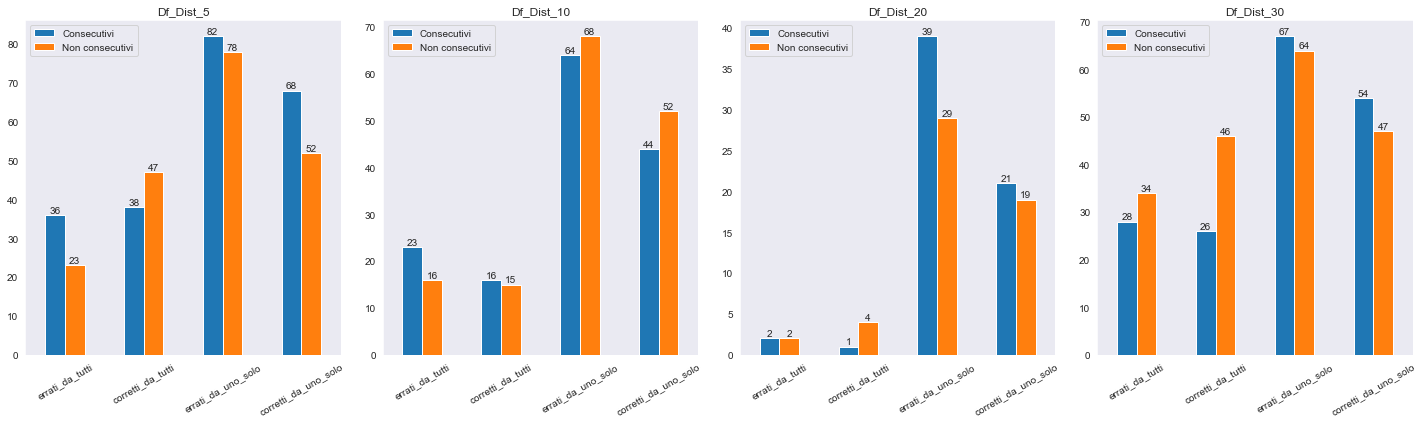

In [120]:
sns.set_style("dark")
fig, axs = plt.subplots(figsize=(20,6),nrows=1, ncols=4)
pd.DataFrame.from_dict(dettaglio_classi_intersezioni_svm['df_dist_5'], orient='index').plot(ax=axs[0], kind='bar')
pd.DataFrame.from_dict(dettaglio_classi_intersezioni_svm['df_dist_10'], orient='index').plot(ax=axs[1], kind='bar')
pd.DataFrame.from_dict(dettaglio_classi_intersezioni_svm['df_dist_20'], orient='index').plot(ax=axs[2], kind='bar')
pd.DataFrame.from_dict(dettaglio_classi_intersezioni_svm['df_dist_30'], orient='index').plot(ax=axs[3], kind='bar')

for ax, dist in zip(axs.flat, lista_dist):
    for label in ax.containers:
        ax.bar_label(label)
    
    ax.tick_params(axis='x', labelrotation=30)
    ax.legend(loc='upper left', labels=['Consecutivi', 'Non consecutivi'])
    ax.set_title("{}".format(dist).title())


fig.tight_layout()
title = "TEDx_dettaglio_classi_svm"
fig.savefig(path_images_tit_ridotti + title, dpi=fig.dpi, bbox_inches='tight')
plt.show()

Osservando i grafici notiamo che per la distanza 30 c'è una maggioranza di eventi non consecutivi classificati in modo corretto da tutti i classificatori, mentre nella distanza 20 osserviamo che spesso un solo classificatore ha considerato come consecutivi eventi che non lo erano. In quest'ultima osserviamo anche che ci sono pochi eventi classificati in modo corretto o errato da tutti.
Per quanto riguarda i grafici delle distanze 5 e 10, notiamo che talvolta tutti i classificatori hanno considerato erroneamente degli eventi come consecutivi quando non lo erano.

## Dettaglio Bert

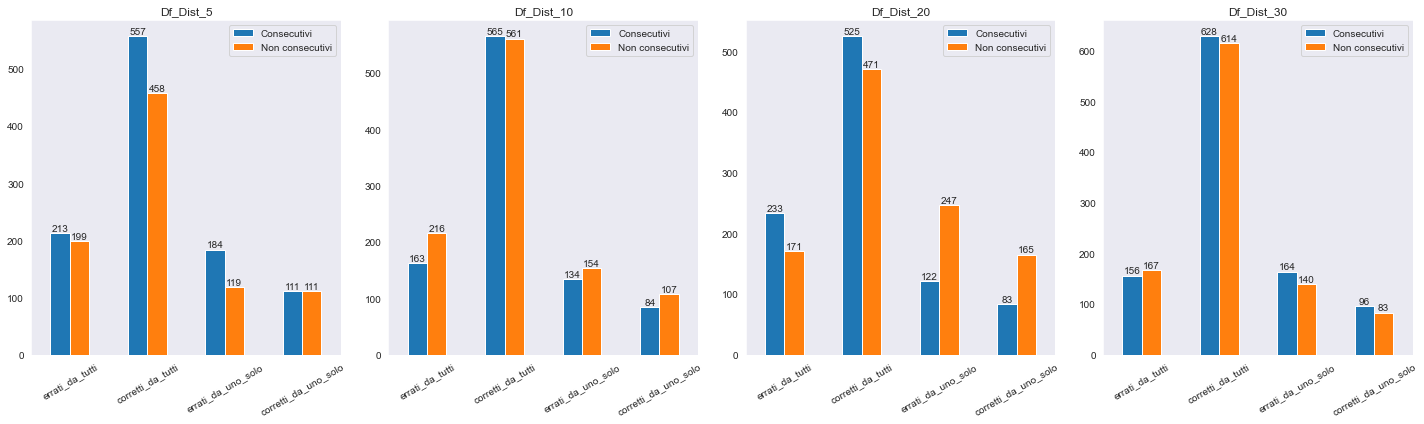

In [121]:
sns.set_style("dark")
fig, axs = plt.subplots(figsize=(20,6),nrows=1, ncols=4)
pd.DataFrame.from_dict(dettaglio_classi_intersezioni_bert['df_dist_5'], orient='index').plot(ax=axs[0], kind='bar')
pd.DataFrame.from_dict(dettaglio_classi_intersezioni_bert['df_dist_10'], orient='index').plot(ax=axs[1], kind='bar')
pd.DataFrame.from_dict(dettaglio_classi_intersezioni_bert['df_dist_20'], orient='index').plot(ax=axs[2], kind='bar')
pd.DataFrame.from_dict(dettaglio_classi_intersezioni_bert['df_dist_30'], orient='index').plot(ax=axs[3], kind='bar')

for ax, dist in zip(axs.flat, lista_dist):
    for label in ax.containers:
        ax.bar_label(label)
  
    ax.tick_params(axis='x', labelrotation=30)
    ax.legend(loc='upper right', labels=['Consecutivi', 'Non consecutivi'])
    ax.set_title("{}".format(dist).title())

fig.tight_layout()
title = "TEDx_dettaglio_classi_bert"
fig.savefig(path_images_tit_ridotti + title, dpi=fig.dpi, bbox_inches='tight')
plt.show()

Per le distanze 10 e 30 osserviamo una quasi parità fra gli eventi consecutivi e non classificati correttamente da tutte le epoche, mentre per le distanze 5 e 20 la maggioranza appartiene alla classe 0.
Un altro particolare che emerge riguarda il confronto fra le distanze 20 e 30: mentre nella prima abbiamo più eventi (etichettati con la classe 1) classificati in modo corretto o errato da una sola epoca, nella distanza 30 vediamo una maggioranza di eventi etichettati con la classe 0.
Se confrontiamo i due scenari di classificazione notiamo che nei dati riguardanti il Bert finetunato è più numeroso l'insieme di eventi classificati in modo corretto da tutti i classificatori o epoche.

# Calcoliamo la percentuale di overlapping

In [122]:
diz_totali_fp_fn_tp_tn_svm = {}

for distanza in lista_dist:
    diz_totali_fp_fn_tp_tn_svm[distanza] = {}
    totale_fp_fn_svm = 0
    totale_tp_tn_svm = 0
    for clf in lista_clf:
        totale_tp_tn_svm += len(diz_global_svm[distanza][clf]['diz_correct_events'])
        totale_fp_fn_svm += len(diz_global_svm[distanza][clf]['misclassified_events'])
    diz_totali_fp_fn_tp_tn_svm[distanza]['totale_tp_tn'] = totale_tp_tn_svm
    diz_totali_fp_fn_tp_tn_svm[distanza]['totale_fp_fn'] = totale_fp_fn_svm

In [123]:
diz_totali_fp_fn_tp_tn_bert = {}

for distanza in lista_dist:
    diz_totali_fp_fn_tp_tn_bert[distanza] = {}
    totale_fp_fn_bert = 0
    totale_tp_tn_bert = 0
    for epoca in lista_epoche:
        totale_tp_tn_bert += len(diz_global_bert[distanza][epoca]['diz_correct_events'])
        totale_fp_fn_bert += len(diz_global_bert[distanza][epoca]['misclassified_events'])
    diz_totali_fp_fn_tp_tn_bert[distanza]['totale_tp_tn'] = totale_tp_tn_bert
    diz_totali_fp_fn_tp_tn_bert[distanza]['totale_fp_fn'] = totale_fp_fn_bert

In [124]:
diz_totali_fp_fn_tp_tn_svm

{'df_dist_5': {'totale_tp_tn': 14928, 'totale_fp_fn': 13872},
 'df_dist_10': {'totale_tp_tn': 14844, 'totale_fp_fn': 13956},
 'df_dist_20': {'totale_tp_tn': 14669, 'totale_fp_fn': 14131},
 'df_dist_30': {'totale_tp_tn': 14603, 'totale_fp_fn': 14197}}

In [125]:
diz_totali_fp_fn_tp_tn_bert

{'df_dist_5': {'totale_tp_tn': 7649, 'totale_fp_fn': 4351},
 'df_dist_10': {'totale_tp_tn': 8024, 'totale_fp_fn': 3976},
 'df_dist_20': {'totale_tp_tn': 7650, 'totale_fp_fn': 4350},
 'df_dist_30': {'totale_tp_tn': 8493, 'totale_fp_fn': 3507}}

In [146]:
#calcolo percentuale della lunghezza di ogni insieme rispetto al totale, per tutti i livelli di complessità

def ottieni_percentuali(dizionario_intersezione_classificatori, list_df_test, diz_totali_fp_fn_tp_tn):
    
    dizionario_percentuali= {}
    
    for distanza, df_test in zip(dizionario_intersezione_classificatori, list_df_test):
    
        print(df_test.shape)
        
        dizionario_percentuali[distanza] = {}
        
        errati_da_tutti = dizionario_intersezione_classificatori[distanza]['intersection_misclassified']
        corretti_da_tutti = dizionario_intersezione_classificatori[distanza]['intersection_correct']
        errati_da_uno_solo = dizionario_intersezione_classificatori[distanza]['other_events_misclassified']
        corretti_da_uno_solo = dizionario_intersezione_classificatori[distanza]['other_events_correct']
        
        print(distanza)
        print("errati_da_tutti", len(errati_da_tutti))
        print("corretti_da_tutti", len(corretti_da_tutti))
        print("errati_da_uno_solo", len(errati_da_uno_solo))
        print("corretti_da_uno_solo", len(corretti_da_uno_solo))
        print()
        print("totale_fp_fn", diz_totali_fp_fn_tp_tn[distanza]['totale_fp_fn'])
        print("totale_tp_tn", diz_totali_fp_fn_tp_tn[distanza]['totale_tp_tn'])
        print()
        
        perc_errati_da_tutti_su_totale_classificati = (len(errati_da_tutti) * 100) / df_test.shape[0]
        perc_corretti_da_tutti_su_totale_classificati = (len(corretti_da_tutti) * 100) / df_test.shape[0]
        perc_errati_da_uno_solo_su_totale_classificati = (len(errati_da_uno_solo) * 100) / df_test.shape[0]
        perc_corretti_da_uno_solo_su_totale_classificati = (len(corretti_da_uno_solo) * 100) / df_test.shape[0]
        
        #perc_errati_da_tutti_su_totale_fp_fn = (len(errati_da_tutti) * 100) / diz_totali_fp_fn_tp_tn[distanza]['totale_fp_fn']
        #perc_corretti_da_tutti_su_totale_tp_tn = (len(corretti_da_tutti) * 100) / diz_totali_fp_fn_tp_tn[distanza]['totale_tp_tn']
        #perc_errati_da_uno_solo_su_totale_fp_fn = (len(errati_da_uno_solo) * 100) / diz_totali_fp_fn_tp_tn[distanza]['totale_fp_fn']
        #perc_corretti_da_uno_solo_su_totale_tp_tn = (len(corretti_da_uno_solo) * 100) / diz_totali_fp_fn_tp_tn[distanza]['totale_tp_tn']
        
        dizionario_percentuali[distanza]['perc_errati_da_tutti_su_totale_classificati'] = "%.2f" % perc_errati_da_tutti_su_totale_classificati + "%"
        dizionario_percentuali[distanza]['perc_corretti_da_tutti_su_totale_classificati'] = "%.2f" % perc_corretti_da_tutti_su_totale_classificati + "%"
        dizionario_percentuali[distanza]['perc_errati_da_uno_solo_su_totale_classificati'] = "%.2f" % perc_errati_da_uno_solo_su_totale_classificati + "%"
        dizionario_percentuali[distanza]['perc_corretti_da_uno_solo_su_totale_classificati'] = "%.2f" % perc_corretti_da_uno_solo_su_totale_classificati + "%"
        
        #dizionario_percentuali[distanza]['perc_errati_da_tutti_su_totale_fp_fn'] = "%.2f" % perc_errati_da_tutti_su_totale_fp_fn + "%"
        #dizionario_percentuali[distanza]['perc_corretti_da_tutti_su_totale_tp_tn'] = "%.2f" % perc_corretti_da_tutti_su_totale_tp_tn + "%"
        #dizionario_percentuali[distanza]['perc_errati_da_uno_solo_su_totale_fp_fn'] = "%.2f" % perc_errati_da_uno_solo_su_totale_fp_fn + "%"
        #dizionario_percentuali[distanza]['perc_corretti_da_uno_solo_su_totale_tp_tn'] = "%.2f" % perc_corretti_da_uno_solo_su_totale_tp_tn + "%"
        
    return dizionario_percentuali

In [147]:
diz_percentuali_svm = ottieni_percentuali(diz_intersections_svm, lista_df_test, diz_totali_fp_fn_tp_tn_svm)

(2400, 4)
df_dist_5
errati_da_tutti 59
corretti_da_tutti 85
errati_da_uno_solo 160
corretti_da_uno_solo 120

totale_fp_fn 13872
totale_tp_tn 14928

(2400, 4)
df_dist_10
errati_da_tutti 39
corretti_da_tutti 31
errati_da_uno_solo 132
corretti_da_uno_solo 96

totale_fp_fn 13956
totale_tp_tn 14844

(2400, 4)
df_dist_20
errati_da_tutti 4
corretti_da_tutti 5
errati_da_uno_solo 68
corretti_da_uno_solo 40

totale_fp_fn 14131
totale_tp_tn 14669

(2400, 4)
df_dist_30
errati_da_tutti 62
corretti_da_tutti 72
errati_da_uno_solo 131
corretti_da_uno_solo 101

totale_fp_fn 14197
totale_tp_tn 14603



In [148]:
diz_percentuali_bert = ottieni_percentuali(diz_intersections_bert, lista_df_test, diz_totali_fp_fn_tp_tn_bert)

(2400, 4)
df_dist_5
errati_da_tutti 412
corretti_da_tutti 1015
errati_da_uno_solo 303
corretti_da_uno_solo 222

totale_fp_fn 4351
totale_tp_tn 7649

(2400, 4)
df_dist_10
errati_da_tutti 379
corretti_da_tutti 1126
errati_da_uno_solo 288
corretti_da_uno_solo 191

totale_fp_fn 3976
totale_tp_tn 8024

(2400, 4)
df_dist_20
errati_da_tutti 404
corretti_da_tutti 996
errati_da_uno_solo 369
corretti_da_uno_solo 248

totale_fp_fn 4350
totale_tp_tn 7650

(2400, 4)
df_dist_30
errati_da_tutti 323
corretti_da_tutti 1242
errati_da_uno_solo 304
corretti_da_uno_solo 179

totale_fp_fn 3507
totale_tp_tn 8493



In [149]:
diz_percentuali_svm

{'df_dist_5': {'perc_errati_da_tutti_su_totale_classificati': '2.46%',
  'perc_corretti_da_tutti_su_totale_classificati': '3.54%',
  'perc_errati_da_uno_solo_su_totale_classificati': '6.67%',
  'perc_corretti_da_uno_solo_su_totale_classificati': '5.00%'},
 'df_dist_10': {'perc_errati_da_tutti_su_totale_classificati': '1.62%',
  'perc_corretti_da_tutti_su_totale_classificati': '1.29%',
  'perc_errati_da_uno_solo_su_totale_classificati': '5.50%',
  'perc_corretti_da_uno_solo_su_totale_classificati': '4.00%'},
 'df_dist_20': {'perc_errati_da_tutti_su_totale_classificati': '0.17%',
  'perc_corretti_da_tutti_su_totale_classificati': '0.21%',
  'perc_errati_da_uno_solo_su_totale_classificati': '2.83%',
  'perc_corretti_da_uno_solo_su_totale_classificati': '1.67%'},
 'df_dist_30': {'perc_errati_da_tutti_su_totale_classificati': '2.58%',
  'perc_corretti_da_tutti_su_totale_classificati': '3.00%',
  'perc_errati_da_uno_solo_su_totale_classificati': '5.46%',
  'perc_corretti_da_uno_solo_su_total

In [150]:
diz_percentuali_bert

{'df_dist_5': {'perc_errati_da_tutti_su_totale_classificati': '17.17%',
  'perc_corretti_da_tutti_su_totale_classificati': '42.29%',
  'perc_errati_da_uno_solo_su_totale_classificati': '12.62%',
  'perc_corretti_da_uno_solo_su_totale_classificati': '9.25%'},
 'df_dist_10': {'perc_errati_da_tutti_su_totale_classificati': '15.79%',
  'perc_corretti_da_tutti_su_totale_classificati': '46.92%',
  'perc_errati_da_uno_solo_su_totale_classificati': '12.00%',
  'perc_corretti_da_uno_solo_su_totale_classificati': '7.96%'},
 'df_dist_20': {'perc_errati_da_tutti_su_totale_classificati': '16.83%',
  'perc_corretti_da_tutti_su_totale_classificati': '41.50%',
  'perc_errati_da_uno_solo_su_totale_classificati': '15.38%',
  'perc_corretti_da_uno_solo_su_totale_classificati': '10.33%'},
 'df_dist_30': {'perc_errati_da_tutti_su_totale_classificati': '13.46%',
  'perc_corretti_da_tutti_su_totale_classificati': '51.75%',
  'perc_errati_da_uno_solo_su_totale_classificati': '12.67%',
  'perc_corretti_da_uno_

In [151]:
df_perc_svm = pd.DataFrame(diz_percentuali_svm).T

df_perc_svm.rename(columns={'classificati_in_modo_sbagliato_da_tutti':"Eventi classificati in modo errato da tutti", \
                         'classificati_correttamente_da_tutti': "Eventi classificati in modo corretto da tutti", \
                          'classificati_in_modo_sbagliato_da_uno_solo': "Eventi classificati in modo errato da uno solo", \
                          'classificati_correttamente_da_uno_solo': "Eventi classificati in modo corretto da uno solo"}, 
                  inplace=True)

In [152]:
df_perc_svm

perc_errati_da_tutti_su_totale_classificati  \
df_dist_5                                        2.46%   
df_dist_10                                       1.62%   
df_dist_20                                       0.17%   
df_dist_30                                       2.58%   

           perc_corretti_da_tutti_su_totale_classificati  \
df_dist_5                                          3.54%   
df_dist_10                                         1.29%   
df_dist_20                                         0.21%   
df_dist_30                                         3.00%   

           perc_errati_da_uno_solo_su_totale_classificati  \
df_dist_5                                           6.67%   
df_dist_10                                          5.50%   
df_dist_20                                          2.83%   
df_dist_30                                          5.46%   

           perc_corretti_da_uno_solo_su_totale_classificati  
df_dist_5                                             5.00%  
df_dist_10                                            4.00%  
df_dist_20                                            1.67%  
df_dist_30                                            4.21%

Osservando la tabella notiamo subito che per tutte le distanze, eccetto la 10, la percentuale più alta appartiene agli eventi classificati in modo corretto da tutti i classificatori, e il valore più alto è dimostrato dalla distanza 5.
Lo stesso primato vale per gli eventi classificati in modo corretto o errato da un solo classificatore.
Non si registra una grande differenza fra le percentuali di eventi classificati in modo corretto o meno da un solo classificatore o da tutti.

In [153]:
df_perc_bert = pd.DataFrame(diz_percentuali_bert).T

df_perc_bert.rename(columns={'classificati_in_modo_sbagliato_da_tutti':"Eventi classificati in modo errato da tutte", \
                         'classificati_correttamente_da_tutti': "Eventi classificati in modo corretto da tutte", \
                          'classificati_in_modo_sbagliato_da_uno_solo': "Eventi classificati in modo errato da una sola", \
                          'classificati_correttamente_da_uno_solo': "Eventi classificati in modo corretto da una sola"}, 
                  inplace=True)

In [154]:
df_perc_bert

perc_errati_da_tutti_su_totale_classificati  \
df_dist_5                                       17.17%   
df_dist_10                                      15.79%   
df_dist_20                                      16.83%   
df_dist_30                                      13.46%   

           perc_corretti_da_tutti_su_totale_classificati  \
df_dist_5                                         42.29%   
df_dist_10                                        46.92%   
df_dist_20                                        41.50%   
df_dist_30                                        51.75%   

           perc_errati_da_uno_solo_su_totale_classificati  \
df_dist_5                                          12.62%   
df_dist_10                                         12.00%   
df_dist_20                                         15.38%   
df_dist_30                                         12.67%   

           perc_corretti_da_uno_solo_su_totale_classificati  
df_dist_5                                             9.25%  
df_dist_10                                            7.96%  
df_dist_20                                           10.33%  
df_dist_30                                            7.46%

In questo caso vediamo che il valore più alto della percentuale di eventi classificati in modo corretto da tutte le epoche appartiene, come atteso, alla distanza 30, mentre sono più numerosi gli eventi classificati in modo errato da tutte le epoche per la distannza 5. Per quanto riguardd le distanze intermedie (10 e 20) non c'è una grande differenza, in entrambi i casi. 
Per quanto concerne le performance riguardanti una sola epoca, per la distanza 20 notiamo che ci sono più eventi classificati bene o male dda una sola epoca.

Da un punto di vista più generale, inoltre, osserviamo che, mentre c'è meno distanza fra le percentuali di eventi classificati in modo corretto o errato da una sola epoca e gli eventi classificati in modo sbagliato da tutte le epoche, questo non vale per il confronto con la percentuale di eventi classificati in modo corretto da tutte le epoche, infatti osserviamo valori sono nettamente maggiori, per tutti i livelli di complessità.

In [155]:
save_dataframe('df_perc_svm', df_perc_svm)

File salvato correttamente


In [156]:
save_dataframe('df_perc_bert', df_perc_bert)

File salvato correttamente


In [137]:
# per ogni distanza calcolo la percentuale di TP/FP e TN/FN sul totale di eventi classificati correttamente o meno
# da tutti i classificatori o da tutte le epoche

def ottieni_percentuali_tp_fp_tn_fn(dizionario_classificatori, list_df_test, diz_global, lista_clf_epoch, modello):
    
    dizionario_percentuali = {}
    
    for distanza, df_test in zip(dizionario_classificatori, list_df_test):
    
        print("Distanza {} - test shape: {}".format(distanza, df_test.shape))
        print()
        dizionario_percentuali[distanza] = {}
        
        errati_da_tutti = dizionario_classificatori[distanza]['intersection_misclassified']
        corretti_da_tutti = dizionario_classificatori[distanza]['intersection_correct']
        errati_da_uno_solo = dizionario_classificatori[distanza]['other_events_misclassified']
        corretti_da_uno_solo = dizionario_classificatori[distanza]['other_events_correct']
        
        dizionario_errati_corretti = {}
        dizionario_errati_corretti['errati_da_tutti'] = errati_da_tutti
        dizionario_errati_corretti['corretti_da_tutti'] = corretti_da_tutti
        dizionario_errati_corretti['errati_da_uno_solo'] = errati_da_uno_solo
        dizionario_errati_corretti['corretti_da_uno_solo'] = corretti_da_uno_solo
        
        diz_tp_fp_tn_fn = get_liste_tp_fp_tn_fn(distanza, \
                                                dizionario_errati_corretti, \
                                                diz_global, \
                                                lista_clf_epoch, \
                                                dizionario_errati_corretti, modello)
        
        for chiave in dizionario_errati_corretti:
            dizionario_percentuali[distanza][chiave] = {}
            dizionario_percentuali[distanza][chiave]['percentuale_consecutivi'] = "%.2f" % diz_tp_fp_tn_fn[chiave]['percentuale_consecutivi'] + "%"
            dizionario_percentuali[distanza][chiave]['percentuale_non_consecutivi'] = "%.2f" % diz_tp_fp_tn_fn[chiave]['percentuale_non_consecutivi'] + "%"
        
        print()
        
    return dizionario_percentuali

In [138]:
def get_liste_tp_fp_tn_fn(distanza, dizionario_intersezioni_classificatori, diz_global, lista_clf_epoch, \
                          dizionario_errati_corretti, modello):
    
    diz_tp_fp_tn_fn = {}
    
    if modello == 'svm':
        num_classificazioni_comuni = 12
    else:
        num_classificazioni_comuni = 5
    
    for chiave in dizionario_errati_corretti:
        
        diz_tp_fp_tn_fn[chiave] = {}
        
        consecutivi = []
        non_consecutivi = []
        
        # per ogni chiave voglio la quantità di esempi non_consecutivi e consecutivi rispetto al totale
        for evento in dizionario_errati_corretti[chiave]:
            
            # False Positive / False Negative
            if chiave == 'errati_da_tutti':
                lista_esiti_clf = []
                
                for clf_epoch in lista_clf_epoch:
                    esito_evento = diz_global[distanza][clf_epoch]['misclassified_events'][evento]
                    
                    if esito_evento['new_value'] == esito_evento['old_value']:
                        print("Errore errati_da_tutti! Ho trovato esempi uguali per l'evento {} (complessità {})".format(evento, \
                                                                                                          distanza))
                    lista_esiti_clf.append(esito_evento['new_value'])
                
                if len(lista_esiti_clf) != num_classificazioni_comuni:
                    print(lista_esiti_clf)
                    print("Errore errati_da_tutti! la lista delle classificazioni non e' di lunghezza pari a {}!".format(num_classificazioni_comuni))
                
                lista_esiti_clf = set(lista_esiti_clf)
                if len(lista_esiti_clf) > 1:
                    print(lista_esiti_clf)
                    print("Errore errati_da_tutti! Ho trovato esempi uguali per l'evento {} (complessità {} e clf {})".format(evento,distanza, clf_epoch))
                else:
                    esito_evento = list(lista_esiti_clf)[0]
                    if esito_evento == 1:
                        non_consecutivi.append(evento)
                    elif esito_evento == 0:
                        consecutivi.append(evento)
            
            # True Positive / True Negative
            elif chiave == 'corretti_da_tutti':
                lista_esiti_clf = []

                for clf_epoch in lista_clf_epoch:
                    esito_evento = diz_global[distanza][clf_epoch]['diz_correct_events'][evento]
                    if esito_evento == None:
                        print("Errore! Non ho trovato l'evento {} per il classificatore {}".format(evento, clf_epoch))
                    else:
                        lista_esiti_clf.append(esito_evento)
                    
                if len(lista_esiti_clf) != num_classificazioni_comuni:
                    print(lista_esiti_clf)
                    print("Errore corretti_da_tutti! la lista delle classificazioni non e' di lunghezza pari a {}!".format(num_classificazioni_comuni))
                
                lista_esiti_clf = set(lista_esiti_clf)
                if len(lista_esiti_clf) > 1:
                    print(lista_esiti_clf)
                    print("Errore corretti_da_tutti! Ho trovato esempi uguali per l'evento {} (complessità {} e clf {})".format(evento,distanza, clf_epoch))
                else:
                    esito_evento = list(lista_esiti_clf)[0]
                    if esito_evento == 1:
                        non_consecutivi.append(evento)
                    elif esito_evento == 0:
                        consecutivi.append(evento)
                    
            elif chiave == 'errati_da_uno_solo':
                lista_esiti_clf = []
                
                for clf_epoch in lista_clf_epoch:
                    if diz_global[distanza][clf_epoch]['misclassified_events'].get(evento):
                        esito_evento = diz_global[distanza][clf_epoch]['misclassified_events'][evento]
                        lista_esiti_clf.append(esito_evento['new_value'])
                        
                if len(lista_esiti_clf) > 1:
                    #print(lista_esiti_clf)
                    print("Errore errati_da_uno_solo! Ho trovato esempi uguali per l'evento {} (complessità {} e clf {})".format(evento,distanza, clf_epoch))
                elif len(lista_esiti_clf) == 0:
                    print("Errore errati_da_uno_solo! lista vuota! {} (complessità {} e clf {})".format(evento,distanza, clf_epoch))
                else:
                    esito_evento = lista_esiti_clf[0]
                    if esito_evento == 1:
                        non_consecutivi.append(evento)
                    elif esito_evento == 0:
                        consecutivi.append(evento)
                        
            elif chiave == 'corretti_da_uno_solo':
                lista_esiti_clf = []
                
                for clf_epoch in lista_clf_epoch:
                    result = diz_global[distanza][clf_epoch]['diz_correct_events'].get(evento)
                    if result != None:
                        esito_evento = result
                        lista_esiti_clf.append(esito_evento)
        
                if len(lista_esiti_clf) > 1:
                    print("Errore corretti_da_uno_solo! Ho trovato esempi uguali per l'evento {} (complessità {} e clf {})".format(evento,distanza, clf_epoch))
                elif len(lista_esiti_clf) == 0:
                    print("Errore corretti_da_uno_solo! lista vuota! {} (complessità {} e clf {})".format(evento,distanza, clf_epoch))
                else:
                    esito_evento = lista_esiti_clf[0]
                    if esito_evento == 1:
                        non_consecutivi.append(evento)
                    elif esito_evento == 0:
                        consecutivi.append(evento)
        
        print("{}: {} ----> consecutivi({}) + non_consecutivi({}) = {}".format(chiave, \
                                                                    len(dizionario_errati_corretti[chiave]), \
                                                                    len(consecutivi), \
                                                                    len(non_consecutivi), \
                                                                    len(consecutivi)+len(non_consecutivi)))
        diz_tp_fp_tn_fn[chiave]['consecutivi'] = consecutivi
        diz_tp_fp_tn_fn[chiave]['non_consecutivi'] = non_consecutivi
        diz_tp_fp_tn_fn[chiave]['percentuale_consecutivi'] = (len(consecutivi) * 100) / len(dizionario_errati_corretti[chiave])
        diz_tp_fp_tn_fn[chiave]['percentuale_non_consecutivi'] = (len(non_consecutivi) * 100) / len(dizionario_errati_corretti[chiave])
              
    return diz_tp_fp_tn_fn

In [139]:
percentuali_tp_fp_tn_fn_svm = ottieni_percentuali_tp_fp_tn_fn(diz_intersections_svm, lista_df_test, \
                                                              diz_global_svm, lista_clf, 'svm')

Distanza df_dist_5 - test shape: (2400, 4)

errati_da_tutti: 59 ----> consecutivi(36) + non_consecutivi(23) = 59
corretti_da_tutti: 85 ----> consecutivi(38) + non_consecutivi(47) = 85
errati_da_uno_solo: 160 ----> consecutivi(82) + non_consecutivi(78) = 160
corretti_da_uno_solo: 120 ----> consecutivi(68) + non_consecutivi(52) = 120

Distanza df_dist_10 - test shape: (2400, 4)

errati_da_tutti: 39 ----> consecutivi(23) + non_consecutivi(16) = 39
corretti_da_tutti: 31 ----> consecutivi(16) + non_consecutivi(15) = 31
errati_da_uno_solo: 132 ----> consecutivi(64) + non_consecutivi(68) = 132
corretti_da_uno_solo: 96 ----> consecutivi(44) + non_consecutivi(52) = 96

Distanza df_dist_20 - test shape: (2400, 4)

errati_da_tutti: 4 ----> consecutivi(2) + non_consecutivi(2) = 4
corretti_da_tutti: 5 ----> consecutivi(1) + non_consecutivi(4) = 5
errati_da_uno_solo: 68 ----> consecutivi(39) + non_consecutivi(29) = 68
corretti_da_uno_solo: 40 ----> consecutivi(21) + non_consecutivi(19) = 40

Distanz

In [140]:
percentuali_tp_fp_tn_fn_bert = ottieni_percentuali_tp_fp_tn_fn(diz_intersections_bert, lista_df_test, \
                                                              diz_global_bert, lista_epoche, 'bert')

Distanza df_dist_5 - test shape: (2400, 4)

errati_da_tutti: 412 ----> consecutivi(213) + non_consecutivi(199) = 412
corretti_da_tutti: 1015 ----> consecutivi(557) + non_consecutivi(458) = 1015
errati_da_uno_solo: 303 ----> consecutivi(184) + non_consecutivi(119) = 303
corretti_da_uno_solo: 222 ----> consecutivi(111) + non_consecutivi(111) = 222

Distanza df_dist_10 - test shape: (2400, 4)

errati_da_tutti: 379 ----> consecutivi(163) + non_consecutivi(216) = 379
corretti_da_tutti: 1126 ----> consecutivi(565) + non_consecutivi(561) = 1126
errati_da_uno_solo: 288 ----> consecutivi(134) + non_consecutivi(154) = 288
corretti_da_uno_solo: 191 ----> consecutivi(84) + non_consecutivi(107) = 191

Distanza df_dist_20 - test shape: (2400, 4)

errati_da_tutti: 404 ----> consecutivi(233) + non_consecutivi(171) = 404
corretti_da_tutti: 996 ----> consecutivi(525) + non_consecutivi(471) = 996
errati_da_uno_solo: 369 ----> consecutivi(122) + non_consecutivi(247) = 369
corretti_da_uno_solo: 248 ----> c

In [141]:
percentuali_tp_fp_tn_fn_svm

{'df_dist_5': {'errati_da_tutti': {'percentuale_consecutivi': '61.02%',
   'percentuale_non_consecutivi': '38.98%'},
  'corretti_da_tutti': {'percentuale_consecutivi': '44.71%',
   'percentuale_non_consecutivi': '55.29%'},
  'errati_da_uno_solo': {'percentuale_consecutivi': '51.25%',
   'percentuale_non_consecutivi': '48.75%'},
  'corretti_da_uno_solo': {'percentuale_consecutivi': '56.67%',
   'percentuale_non_consecutivi': '43.33%'}},
 'df_dist_10': {'errati_da_tutti': {'percentuale_consecutivi': '58.97%',
   'percentuale_non_consecutivi': '41.03%'},
  'corretti_da_tutti': {'percentuale_consecutivi': '51.61%',
   'percentuale_non_consecutivi': '48.39%'},
  'errati_da_uno_solo': {'percentuale_consecutivi': '48.48%',
   'percentuale_non_consecutivi': '51.52%'},
  'corretti_da_uno_solo': {'percentuale_consecutivi': '45.83%',
   'percentuale_non_consecutivi': '54.17%'}},
 'df_dist_20': {'errati_da_tutti': {'percentuale_consecutivi': '50.00%',
   'percentuale_non_consecutivi': '50.00%'},
 

In [142]:
percentuali_tp_fp_tn_fn_bert

{'df_dist_5': {'errati_da_tutti': {'percentuale_consecutivi': '51.70%',
   'percentuale_non_consecutivi': '48.30%'},
  'corretti_da_tutti': {'percentuale_consecutivi': '54.88%',
   'percentuale_non_consecutivi': '45.12%'},
  'errati_da_uno_solo': {'percentuale_consecutivi': '60.73%',
   'percentuale_non_consecutivi': '39.27%'},
  'corretti_da_uno_solo': {'percentuale_consecutivi': '50.00%',
   'percentuale_non_consecutivi': '50.00%'}},
 'df_dist_10': {'errati_da_tutti': {'percentuale_consecutivi': '43.01%',
   'percentuale_non_consecutivi': '56.99%'},
  'corretti_da_tutti': {'percentuale_consecutivi': '50.18%',
   'percentuale_non_consecutivi': '49.82%'},
  'errati_da_uno_solo': {'percentuale_consecutivi': '46.53%',
   'percentuale_non_consecutivi': '53.47%'},
  'corretti_da_uno_solo': {'percentuale_consecutivi': '43.98%',
   'percentuale_non_consecutivi': '56.02%'}},
 'df_dist_20': {'errati_da_tutti': {'percentuale_consecutivi': '57.67%',
   'percentuale_non_consecutivi': '42.33%'},
 

In [138]:
df_perc_svm_specifica_perc = pd.DataFrame.from_dict({(i,j): percentuali_tp_fp_tn_fn_svm[i][j] 
                           for i in percentuali_tp_fp_tn_fn_svm.keys() 
                           for j in percentuali_tp_fp_tn_fn_svm[i].keys()},
                       orient='index')

In [139]:
df_perc_svm_specifica_perc

percentuale_consecutivi  \
df_dist_5  errati_da_tutti                       61.02%   
           corretti_da_tutti                     44.71%   
           errati_da_uno_solo                    51.25%   
           corretti_da_uno_solo                  56.67%   
df_dist_10 errati_da_tutti                       58.97%   
           corretti_da_tutti                     51.61%   
           errati_da_uno_solo                    48.48%   
           corretti_da_uno_solo                  45.83%   
df_dist_20 errati_da_tutti                       50.00%   
           corretti_da_tutti                     20.00%   
           errati_da_uno_solo                    57.35%   
           corretti_da_uno_solo                  52.50%   
df_dist_30 errati_da_tutti                       45.16%   
           corretti_da_tutti                     36.11%   
           errati_da_uno_solo                    51.15%   
           corretti_da_uno_solo                  53.47%   

                                percentuale_non_consecutivi  
df_dist_5  errati_da_tutti                           38.98%  
           corretti_da_tutti                         55.29%  
           errati_da_uno_solo                        48.75%  
           corretti_da_uno_solo                      43.33%  
df_dist_10 errati_da_tutti                           41.03%  
           corretti_da_tutti                         48.39%  
           errati_da_uno_solo                        51.52%  
           corretti_da_uno_solo                      54.17%  
df_dist_20 errati_da_tutti                           50.00%  
           corretti_da_tutti                         80.00%  
           errati_da_uno_solo                        42.65%  
           corretti_da_uno_solo                      47.50%  
df_dist_30 errati_da_tutti                           54.84%  
           corretti_da_tutti                         63.89%  
           errati_da_uno_solo                        48.85%  
           corretti_da_uno_solo                      46.53%

In [140]:
df_perc_bert_specifica_perc = pd.DataFrame.from_dict({(i,j): percentuali_tp_fp_tn_fn_bert[i][j] 
                           for i in percentuali_tp_fp_tn_fn_bert.keys() 
                           for j in percentuali_tp_fp_tn_fn_bert[i].keys()},
                       orient='index')

In [141]:
df_perc_bert_specifica_perc

percentuale_consecutivi  \
df_dist_5  errati_da_tutti                       51.70%   
           corretti_da_tutti                     54.88%   
           errati_da_uno_solo                    60.73%   
           corretti_da_uno_solo                  50.00%   
df_dist_10 errati_da_tutti                       43.01%   
           corretti_da_tutti                     50.18%   
           errati_da_uno_solo                    46.53%   
           corretti_da_uno_solo                  43.98%   
df_dist_20 errati_da_tutti                       57.67%   
           corretti_da_tutti                     52.71%   
           errati_da_uno_solo                    33.06%   
           corretti_da_uno_solo                  33.47%   
df_dist_30 errati_da_tutti                       48.30%   
           corretti_da_tutti                     50.56%   
           errati_da_uno_solo                    53.95%   
           corretti_da_uno_solo                  53.63%   

                                percentuale_non_consecutivi  
df_dist_5  errati_da_tutti                           48.30%  
           corretti_da_tutti                         45.12%  
           errati_da_uno_solo                        39.27%  
           corretti_da_uno_solo                      50.00%  
df_dist_10 errati_da_tutti                           56.99%  
           corretti_da_tutti                         49.82%  
           errati_da_uno_solo                        53.47%  
           corretti_da_uno_solo                      56.02%  
df_dist_20 errati_da_tutti                           42.33%  
           corretti_da_tutti                         47.29%  
           errati_da_uno_solo                        66.94%  
           corretti_da_uno_solo                      66.53%  
df_dist_30 errati_da_tutti                           51.70%  
           corretti_da_tutti                         49.44%  
           errati_da_uno_solo                        46.05%  
           corretti_da_uno_solo                      46.37%

In [142]:
save_dataframe('df_perc_svm_specifica_perc', df_perc_svm_specifica_perc)

File salvato correttamente


In [143]:
save_dataframe('df_perc_bert_specifica_perc', df_perc_bert_specifica_perc)

File salvato correttamente


### Selezioniamo alcuni esempi di eventi da mostrare per i confronti interni ai modelli

In [21]:
def get_interventi_scelti_intersezione_confronti_interni(diz, lista_dist):
    
    diz_dist = {}
    
    for dist in lista_dist:
        
        diz_dist[dist] = {}
        
        #classificati bene o male da tutti i clf o epoche
        lista_eventi_scelti_intersezione_errati = random.sample(diz[dist]['intersection_misclassified'], 4)
        lista_eventi_scelti_intersezione_corretti = random.sample(diz[dist]['intersection_correct'], 4)
         
        #classificati bene o male solo da un clf o un'epoca
        lista_eventi_scelti_intersezione_altri_errati = random.sample(diz[dist]['other_events_misclassified'], 4)
        lista_eventi_scelti_intersezione_altri_corretti = random.sample(diz[dist]['other_events_correct'], 4)
        
        diz_dist[dist]['lista_eventi_scelti_intersezione_errati'] = lista_eventi_scelti_intersezione_errati
        diz_dist[dist]['lista_eventi_scelti_intersezione_corretti'] = lista_eventi_scelti_intersezione_corretti
        diz_dist[dist]['lista_eventi_scelti_intersezione_altri_errati'] = lista_eventi_scelti_intersezione_altri_errati
        diz_dist[dist]['lista_eventi_scelti_intersezione_altri_corretti'] = lista_eventi_scelti_intersezione_altri_corretti
        
    return diz_dist

In [22]:
diz_dist_svm_table = get_interventi_scelti_intersezione_confronti_interni(diz_intersections_svm, lista_dist)

In [23]:
diz_dist_bert_table = get_interventi_scelti_intersezione_confronti_interni(diz_intersections_bert, lista_dist)

### Selezioniamo alcuni esempi da mostrare per i confronti incrociati, ovvero prendiamo alcuni esempi di eventi classificati bene o male da tutti i clf o le epoche dei differenti modelli e confrontiamo i risultati delle classificazioni

In [24]:
def get_confronti_incrociati(lista_dist, diz_svm, diz_bert):
    
    diz_confronti_incrociati = {}
    
    for dist in lista_dist:
        
        diz_confronti_incrociati[dist] = {}
        
        diz_confronti_incrociati[dist]['lista_eventi_scelti_intersezione_errati'] = []
        diz_confronti_incrociati[dist]['lista_eventi_scelti_intersezione_corretti'] = []
        
        eventi_classificati_male_svm = random.sample(diz_svm[dist]['lista_eventi_scelti_intersezione_errati'], 3)
        eventi_classificati_male_bert = random.sample(diz_bert[dist]['lista_eventi_scelti_intersezione_errati'], 3)
        
        eventi_classificati_bene_svm = random.sample(diz_svm[dist]['lista_eventi_scelti_intersezione_corretti'], 3)
        eventi_classificati_bene_bert = random.sample(diz_svm[dist]['lista_eventi_scelti_intersezione_corretti'], 3)
        
        diz_confronti_incrociati[dist]['lista_eventi_scelti_intersezione_errati'].extend(eventi_classificati_male_svm)
        diz_confronti_incrociati[dist]['lista_eventi_scelti_intersezione_errati'].extend(eventi_classificati_male_bert)
        
        diz_confronti_incrociati[dist]['lista_eventi_scelti_intersezione_corretti'].extend(eventi_classificati_bene_svm)
        diz_confronti_incrociati[dist]['lista_eventi_scelti_intersezione_corretti'].extend(eventi_classificati_bene_bert)
        
        
    return diz_confronti_incrociati

In [25]:
diz_confronti_incrociati = get_confronti_incrociati(lista_dist, diz_dist_svm_table, diz_dist_bert_table)

In [26]:
diz_confronti_incrociati

{'df_dist_5': {'lista_eventi_scelti_intersezione_errati': [122891,
   178915,
   149296,
   150821,
   5575,
   11908],
  'lista_eventi_scelti_intersezione_corretti': [23286,
   155973,
   75655,
   92955,
   75655,
   155973]},
 'df_dist_10': {'lista_eventi_scelti_intersezione_errati': [199708,
   86547,
   17682,
   3558,
   85068,
   107738],
  'lista_eventi_scelti_intersezione_corretti': [120997,
   100632,
   91036,
   120997,
   100632,
   91036]},
 'df_dist_20': {'lista_eventi_scelti_intersezione_errati': [197250,
   37765,
   13221,
   96616,
   115285,
   112751],
  'lista_eventi_scelti_intersezione_corretti': [103749,
   31798,
   134949,
   134949,
   103749,
   196531]},
 'df_dist_30': {'lista_eventi_scelti_intersezione_errati': [46179,
   57496,
   154154,
   55700,
   181717,
   199643],
  'lista_eventi_scelti_intersezione_corretti': [173219,
   165511,
   27234,
   165511,
   173219,
   172416]}}

In [27]:
diz_dist_svm_table

{'df_dist_5': {'lista_eventi_scelti_intersezione_errati': [105167,
   149296,
   178915,
   122891],
  'lista_eventi_scelti_intersezione_corretti': [23286, 155973, 92955, 75655],
  'lista_eventi_scelti_intersezione_altri_errati': [50178,
   166701,
   99703,
   198866],
  'lista_eventi_scelti_intersezione_altri_corretti': [892,
   4249,
   8929,
   140002]},
 'df_dist_10': {'lista_eventi_scelti_intersezione_errati': [86547,
   94213,
   199708,
   17682],
  'lista_eventi_scelti_intersezione_corretti': [100632, 120997, 119171, 91036],
  'lista_eventi_scelti_intersezione_altri_errati': [29166,
   148586,
   30087,
   161961],
  'lista_eventi_scelti_intersezione_altri_corretti': [65533,
   40700,
   165440,
   139908]},
 'df_dist_20': {'lista_eventi_scelti_intersezione_errati': [197250,
   37765,
   13221,
   8397],
  'lista_eventi_scelti_intersezione_corretti': [31798, 134949, 103749, 196531],
  'lista_eventi_scelti_intersezione_altri_errati': [8121,
   192302,
   118989,
   196378],
  '

In [28]:
diz_dist_bert_table

{'df_dist_5': {'lista_eventi_scelti_intersezione_errati': [5575,
   2359,
   11908,
   150821],
  'lista_eventi_scelti_intersezione_corretti': [162611, 58238, 74052, 125450],
  'lista_eventi_scelti_intersezione_altri_errati': [138986,
   141297,
   111028,
   99619],
  'lista_eventi_scelti_intersezione_altri_corretti': [55291,
   182248,
   109227,
   112027]},
 'df_dist_10': {'lista_eventi_scelti_intersezione_errati': [85068,
   62092,
   3558,
   107738],
  'lista_eventi_scelti_intersezione_corretti': [179788, 138432, 195781, 61874],
  'lista_eventi_scelti_intersezione_altri_errati': [78220, 1171, 71616, 17892],
  'lista_eventi_scelti_intersezione_altri_corretti': [152982,
   126332,
   26147,
   127824]},
 'df_dist_20': {'lista_eventi_scelti_intersezione_errati': [189569,
   96616,
   112751,
   115285],
  'lista_eventi_scelti_intersezione_corretti': [7206, 86881, 40916, 109205],
  'lista_eventi_scelti_intersezione_altri_errati': [110963,
   64979,
   113747,
   165652],
  'lista_ev

In [29]:
a = {'eleonora': {'prova': 1, 'ciao': 2}}

pd.DataFrame.from_dict(a, orient='index', columns=['prova', 'ciao'])

prova  ciao
eleonora      1     2

In [132]:
def costruisci_tabella_confronti_interni(diz_eventi_scelti, lista_dist, clf_epoch_list, \
                                         lista_df_test, lista_diz_pred):
    
    diz_total = {}
    
    for df_test, dist, diz_pred in tqdm(zip(lista_df_test, lista_dist, lista_diz_pred)):
        
        diz_total[dist] = {}
        
        for key in diz_eventi_scelti[dist]:
            
            diz_total[dist][key] = {}
            
            for evento in diz_eventi_scelti[dist][key]:
                val = df_test[df_test['Id'] == evento][['Sentence_1', 'Sentence_2', 'Class']].to_dict(orient='index')
                val_k = list(val.keys())[0]
                diz_total[dist][key][evento] = val[val_k]
                
                if key in ('lista_eventi_scelti_intersezione_errati', 'lista_eventi_scelti_intersezione_corretti'):
                    
                    #se trattiamo l'intersezione fra clf a parità di distanza (complessità del dataset)
                    #prendo la classe predetta dal primo classificatore per comodità
                    classe_predetta = diz_pred[dist][clf_epoch_list[0]]['ids_preds'][evento]
                    
                    diz_total[dist][key][evento].update({
                        'Pred': classe_predetta
                    })
                    
                    for clf_epoch in clf_epoch_list:
                        diz_total[dist][key][evento].update({ \
                            "{}P".format(clf_epoch) : "%.2f"%diz_pred[dist][clf_epoch]['ids_proba'][evento][classe_predetta]
                        })
                elif key in ('lista_eventi_scelti_intersezione_altri_errati', 'lista_eventi_scelti_intersezione_altri_corretti'):
                    
                    for clf_epoch in clf_epoch_list:
                        diz_total[dist][key][evento].update({ \
                            "{}pr".format(clf_epoch.replace('lf_', '')) : diz_pred[dist][clf_epoch]['ids_preds'][evento], \
                            "{}P".format(clf_epoch.replace('lf_', '')) : "%.2f"%max(diz_pred[dist][clf_epoch]['ids_proba'][evento])
                        })
                        
                        
    return diz_total

In [133]:
def costruisci_tabella_confronti_incrociati(diz_eventi_scelti, lista_dist, clf_epoch_list, \
                                            lista_df_test, lista_diz_pred):
    
    diz_total = {}
    
    for df_test, dist, diz_pred in tqdm(zip(lista_df_test, lista_dist, lista_diz_pred)):
        
        diz_total[dist] = {}
        
        for key in diz_eventi_scelti[dist]:
            
            diz_total[dist][key] = {}
            
            for evento in diz_eventi_scelti[dist][key]:
                val = df_test[df_test['Id'] == evento][['Sentence_1', 'Sentence_2', 'Class']].to_dict(orient='index')
                val_k = list(val.keys())[0]
                diz_total[dist][key][evento] = val[val_k]
                
                for clf_epoch in clf_epoch_list:
                    diz_total[dist][key][evento].update({ \
                        "{}pred".format(clf_epoch.replace('lf_', '')) : diz_pred[dist][clf_epoch]['ids_preds'][evento], 
                        "{}P".format(clf_epoch.replace('lf_', '')) : "%.2f"%max(diz_pred[dist][clf_epoch]['ids_proba'][evento])
                    })
                        
                        
    return diz_total

In [134]:
for clf in lista_clf:
    print(clf, lista_diz_pred_svm[0]['df_dist_5'][clf]['ids_preds'][140820])

clf_1 0
clf_2 0
clf_3 0
clf_4 0
clf_5 0
clf_6 0
clf_7 0
clf_8 0
clf_9 0
clf_10 0
clf_11 0
clf_12 0


In [135]:
diz_tabella_total_svm = costruisci_tabella_confronti_interni(diz_dist_svm_table, lista_dist, lista_clf, \
                                                             lista_df_test, lista_diz_pred_svm)

4it [00:00, 46.31it/s]


In [136]:
diz_tabella_total_bert = costruisci_tabella_confronti_interni(diz_dist_bert_table, lista_dist, lista_epoche, \
                                                             lista_df_test, lista_diz_pred_bert_finetunato)

4it [00:00, 50.35it/s]


In [137]:
diz_confronti_incrociati_svm = costruisci_tabella_confronti_incrociati(diz_dist_svm_table, lista_dist, lista_clf, \
                                                            lista_df_test, lista_diz_pred_svm)

4it [00:00, 44.84it/s]


In [138]:
diz_confronti_incrociati_bert = costruisci_tabella_confronti_incrociati(diz_dist_bert_table, lista_dist, lista_epoche, \
                                                             lista_df_test, lista_diz_pred_bert_finetunato)

4it [00:00, 45.22it/s]


In [184]:
def salva_diz(path, diz, name):
    
    with open('{}{}.pickle'.format(path, name), 'wb') as handle:
        pickle.dump(diz, handle)
        
    return "Dizionario salvato correttamente"

In [185]:
salva_diz(path_diz_res, diz_tabella_total_svm, 'diz_tabella_total_svm')

'Dizionario salvato correttamente'

In [186]:
salva_diz(path_diz_res, diz_tabella_total_bert, 'diz_tabella_total_bert')

'Dizionario salvato correttamente'

In [187]:
salva_diz(path_diz_res, diz_confronti_incrociati_svm, 'diz_confronti_incrociati_svm')

'Dizionario salvato correttamente'

In [188]:
salva_diz(path_diz_res, diz_confronti_incrociati_bert, 'diz_confronti_incrociati_bert')

'Dizionario salvato correttamente'

In [139]:
diz_tabella_total_svm

{'df_dist_5': {'lista_eventi_scelti_intersezione_errati': {105167: {'Sentence_1': 'La cosiddetta "wisdom of crowds", un libro del 2004 mai tradotto in italiano.',
    'Sentence_2': "Una persona ha detto, valore più basso, che ce ne sono 70, Il dato reale è di 287: la media raggiunta da voi è 272, l'errore è più o meno pari al 5%.",
    'Class': 1,
    'Pred': 0,
    'clf_1P': '0.51',
    'clf_2P': '0.53',
    'clf_3P': '0.52',
    'clf_4P': '0.51',
    'clf_5P': '0.53',
    'clf_6P': '0.53',
    'clf_7P': '0.53',
    'clf_8P': '0.54',
    'clf_9P': '0.50',
    'clf_10P': '0.51',
    'clf_11P': '0.52',
    'clf_12P': '0.50'},
   149296: {'Sentence_1': "Ma non fidandovi l'uno degli altri, avete paura che possano imbrogliare.",
    'Sentence_2': 'Ad esempio ritagliando di nascosto le fiches o passandosele sotto il tavolo.',
    'Class': 0,
    'Pred': 1,
    'clf_1P': '0.51',
    'clf_2P': '0.51',
    'clf_3P': '0.52',
    'clf_4P': '0.52',
    'clf_5P': '0.53',
    'clf_6P': '0.53',
    

In [140]:
diz_tabella_total_svm['df_dist_5'].keys()

dict_keys(['lista_eventi_scelti_intersezione_errati', 'lista_eventi_scelti_intersezione_corretti', 'lista_eventi_scelti_intersezione_altri_errati', 'lista_eventi_scelti_intersezione_altri_corretti'])

# SVM confronti interni

In [141]:
def salva_dataset_risultati(diz_tabella_modello, modello, lista_dist, risorsa):
    
    for dist in lista_dist:
    
        for k in diz_tabella_modello[dist]:
            df = pd.DataFrame(diz_tabella_modello[dist][k]).T
            save_dataframe("{} - {}_{}_{}".format(risorsa, dist, modello, k), df)

In [142]:
salva_dataset_risultati(diz_tabella_total_svm, 'SVM', lista_dist, risorsa)

File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente


In [143]:
salva_dataset_risultati(diz_tabella_total_bert, 'BERT', lista_dist, risorsa)

File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente


In [144]:
salva_dataset_risultati(diz_confronti_incrociati_svm, 'SVM_incroci', lista_dist, risorsa)

File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente


In [145]:
salva_dataset_risultati(diz_confronti_incrociati_bert, 'BERT_incroci', lista_dist, risorsa)

File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente
File salvato correttamente


In [183]:
pd.DataFrame(diz_tabella_total_bert['df_dist_5']['lista_eventi_scelti_intersezione_altri_corretti']).T

Sentence_1  \
55291               La tecnologia è neutra, quando nasce.   
182248  Sapendo quello che sta succedendo in questo mo...   
109227  Ora, almeno cinque di queste possono essere tr...   
112027          Tieniti forte, mancano solo altri 180 km.   

                                               Sentence_2 Class Epoch0pr  \
55291   Siamo noi che decidiamo come applicarla al mon...     0        0   
182248  E quindi ci siamo intestarditi, abbiamo detto ...     0        0   
109227  Mi concentro solo sul primo, Il complex proble...     0        1   
112027  Nonostante questo pesante pensiero ero determi...     0        1   

       Epoch0P Epoch1pr Epoch1P Epoch2pr Epoch2P Epoch3pr Epoch3P Epoch4pr  \
55291     0.62        1    0.65        1    0.94        1    0.99        1   
182248    0.54        1    0.54        1    0.92        1    1.00        1   
109227    0.53        0    0.52        1    0.61        1    0.75        1   
112027    0.51        1    0.54        1    0.70        1    0.89        0   

       Epoch4P  
55291     0.95  
182248    0.84  
109227    0.56  
112027    0.69

In [91]:
pd.DataFrame(diz_tabella_total_svm['df_dist_5']['lista_eventi_scelti_intersezione_errati']).T

Sentence_1  \
105167  La cosiddetta "wisdom of crowds", un libro del...   
149296  Ma non fidandovi l'uno degli altri, avete paur...   
178915  Quindi interagire con l'intelligenza artificia...   
122891  Oppure sono effettivamente patrimonio, cioè be...   

                                               Sentence_2 Class Pred clf_1_P  \
105167  Una persona ha detto, valore più basso, che ce...     1    0    0.51   
149296  Ad esempio ritagliando di nascosto le fiches o...     0    1    0.51   
178915  Questo non era un robot, era un pupazzo con 87...     1    0    0.51   
122891                                       Un restauro.     1    0    0.51   

       clf_2_P clf_3_P clf_4_P clf_5_P clf_6_P clf_7_P clf_8_P clf_9_P  \
105167    0.53    0.52    0.51    0.53    0.53    0.53    0.54    0.50   
149296    0.51    0.52    0.52    0.53    0.53    0.52    0.51    0.52   
178915    0.52    0.53    0.52    0.53    0.52    0.51    0.50    0.51   
122891    0.53    0.52    0.51    0.51    0.50    0.50    0.55    0.52   

       clf_10_P clf_11_P clf_12_P  
105167     0.51     0.52     0.50  
149296     0.52     0.51     0.51  
178915     0.51     0.50     0.50  
122891     0.51     0.51     0.50

In [92]:
pd.DataFrame(diz_tabella_total_svm['df_dist_5']['lista_eventi_scelti_intersezione_altri_corretti']).T

Sentence_1  \
892     I miei due amici che mi accompagnavano dormiva...   
4249    Pensa a proteggere se stessa, a consumare poch...   
8929    Oppure raccontare di come Brian Acton, quest'a...   
140002  Quindi stiamo cercando di dare il massimo valo...   

                                               Sentence_2 Class clf_1_pred  \
892     Sono uscite due cose: La prima, è che i miei g...     1          1   
4249    Immediatamente scatta un allarme e inonda il s...     1          0   
8929    Perché io credo che la differenza, in fin dei ...     1          0   
140002  Mi piace più parlare di sostenibilità, di prod...     1          0   

       clf_1_P clf_2_pred clf_2_P clf_3_pred clf_3_P clf_4_pred  ...  \
892       0.50          0    0.51          0    0.51          0  ...   
4249      0.50          0    0.52          0    0.51          0  ...   
8929      0.50          1    0.52          0    0.51          0  ...   
140002    0.50          0    0.50          0    0.52          0  ...   

       clf_8_pred clf_8_P clf_9_pred clf_9_P clf_10_pred clf_10_P clf_11_pred  \
892             0    0.50          0    0.51           0     0.51           0   
4249            0    0.52          0    0.51           0     0.50           0   
8929            0    0.51          0    0.51           0     0.51           0   
140002          0    0.52          0    0.51           1     0.50           0   

       clf_11_P clf_12_pred clf_12_P  
892        0.51           0     0.50  
4249       0.50           1     0.51  
8929       0.50           0     0.50  
140002     0.51           0     0.50  

[4 rows x 27 columns]

In [76]:
pd.DataFrame(diz_tabella_total_svm['df_dist_5']['lista_eventi_scelti_intersezione_altri_errati']).T

Sentence_1  \
50178   Però anche tre sogni, a pensarci bene, che bam...   
166701  Le nostre miniere sono sperdute in mezzo ai de...   
99703   Chiediamoci ancora una volta: ma perché questo...   
198866  In che professione rientra fare ciò che compor...   

                                               Sentence_2 Class clf_1_pred  \
50178   Mi viene da sorridere perché di solito, nel mi...     1          1   
166701  Le nostre acciaierie, che produciamo, hanno, d...     0          0   
99703   Mah, insomma, potrei sempre dire: "Va bene, io...     0          1   
198866  Nasce per riuscire a vivere in determinate con...     1          1   

       clf_1_P clf_2_pred clf_2_P clf_3_pred clf_3_P clf_4_pred  ...  \
50178     0.51          1    0.52          1    0.52          1  ...   
166701    0.50          0    0.51          0    0.51          0  ...   
99703     0.50          0    0.50          0    0.51          0  ...   
198866    0.50          1    0.53          1    0.53          1  ...   

       clf_8_pred clf_8_P clf_9_pred clf_9_P clf_10_pred clf_10_P clf_11_pred  \
50178           1    0.52          1    0.53           1     0.51           1   
166701          1    0.50          0    0.50           0     0.51           0   
99703           0    0.51          0    0.52           0     0.51           0   
198866          1    0.51          1    0.52           1     0.50           1   

       clf_11_P clf_12_pred clf_12_P  
50178      0.50           0     0.50  
166701     0.52           0     0.50  
99703      0.51           0     0.50  
198866     0.50           1     0.50  

[4 rows x 27 columns]

In [147]:
diz_confronti_incrociati_svm

{'df_dist_5': {'lista_eventi_scelti_intersezione_errati': {105167: {'Sentence_1': 'La cosiddetta "wisdom of crowds", un libro del 2004 mai tradotto in italiano.',
    'Sentence_2': "Una persona ha detto, valore più basso, che ce ne sono 70, Il dato reale è di 287: la media raggiunta da voi è 272, l'errore è più o meno pari al 5%.",
    'Class': 1,
    'c1pred': 0,
    'c1P': '0.51',
    'c2pred': 0,
    'c2P': '0.53',
    'c3pred': 0,
    'c3P': '0.52',
    'c4pred': 0,
    'c4P': '0.51',
    'c5pred': 0,
    'c5P': '0.53',
    'c6pred': 0,
    'c6P': '0.53',
    'c7pred': 0,
    'c7P': '0.53',
    'c8pred': 0,
    'c8P': '0.54',
    'c9pred': 0,
    'c9P': '0.50',
    'c10pred': 0,
    'c10P': '0.51',
    'c11pred': 0,
    'c11P': '0.52',
    'c12pred': 0,
    'c12P': '0.50'},
   149296: {'Sentence_1': "Ma non fidandovi l'uno degli altri, avete paura che possano imbrogliare.",
    'Sentence_2': 'Ad esempio ritagliando di nascosto le fiches o passandosele sotto il tavolo.',
    'Class'

In [148]:
diz_confronti_incrociati_bert

{'df_dist_5': {'lista_eventi_scelti_intersezione_errati': {5575: {'Sentence_1': 'Nello specifico lui dice: mi ha raccontato questa storia che poi non ha più raccontato negli ultimi 20 anni per cui la socializzo con voi, però lui non la racconta più Come funziona il cervello.',
    'Sentence_2': "Secondo voi cos'è successo?",
    'Class': 1,
    'Epoch0pred': 0,
    'Epoch0P': '0.56',
    'Epoch1pred': 0,
    'Epoch1P': '0.65',
    'Epoch2pred': 0,
    'Epoch2P': '0.56',
    'Epoch3pred': 0,
    'Epoch3P': '0.85',
    'Epoch4pred': 0,
    'Epoch4P': '0.94'},
   2359: {'Sentence_1': 'Rinforzate le parti bianche!',
    'Sentence_2': 'Certo, perché gli aerei che sono rientrati sono stati colpiti, ma probabilmente sono stati colpiti in quei punti che non sono necessari per volare.',
    'Class': 0,
    'Epoch0pred': 1,
    'Epoch0P': '0.70',
    'Epoch1pred': 1,
    'Epoch1P': '0.89',
    'Epoch2pred': 1,
    'Epoch2P': '0.99',
    'Epoch3pred': 1,
    'Epoch3P': '1.00',
    'Epoch4pred': 1

# Indici di leggibilità

Calcoliamo l'indice di leggibilità delle frasi che sono state selezionate, e solo per i dataset considerati per le osservazioni (distanza 5, 30 e random_speech, se presente)

In [9]:
import textstat

https://pypi.org/project/textstat/

**flesch_reading_ease** support italian In the Flesch reading-ease test, higher scores indicate material that is easier to read; lower numbers mark passages that are more difficult to read.

**Gulpease Index (Italian)** Language Specific Formulas Returns the Gulpease index of Italian text, which translates to level of education completed. Lower scores require higher level of education to read with ease.

In [10]:
file_svm_to_read = open(path_diz_res+"diz_tabella_total_svm.pickle", "rb")
tabella_svm = pickle.load(file_svm_to_read)

file_bert_to_read = open(path_diz_res+"diz_tabella_total_bert.pickle", "rb")
tabella_bert = pickle.load(file_bert_to_read)

In [16]:
tabella_svm

{'df_dist_5': {'lista_eventi_scelti_intersezione_errati': {105167: {'Sentence_1': 'La cosiddetta "wisdom of crowds", un libro del 2004 mai tradotto in italiano.',
    'Sentence_2': "Una persona ha detto, valore più basso, che ce ne sono 70, Il dato reale è di 287: la media raggiunta da voi è 272, l'errore è più o meno pari al 5%.",
    'Class': 1,
    'Pred': 0,
    'clf_1P': '0.51',
    'clf_2P': '0.53',
    'clf_3P': '0.52',
    'clf_4P': '0.51',
    'clf_5P': '0.53',
    'clf_6P': '0.53',
    'clf_7P': '0.53',
    'clf_8P': '0.54',
    'clf_9P': '0.50',
    'clf_10P': '0.51',
    'clf_11P': '0.52',
    'clf_12P': '0.50'},
   149296: {'Sentence_1': "Ma non fidandovi l'uno degli altri, avete paura che possano imbrogliare.",
    'Sentence_2': 'Ad esempio ritagliando di nascosto le fiches o passandosele sotto il tavolo.',
    'Class': 0,
    'Pred': 1,
    'clf_1P': '0.51',
    'clf_2P': '0.51',
    'clf_3P': '0.52',
    'clf_4P': '0.52',
    'clf_5P': '0.53',
    'clf_6P': '0.53',
    

In [11]:
distanze_considerate = ['df_dist_5', 'df_dist_30']

In [12]:
def get_tabella_indici_leggibilita(distanze_considerate, tabella):
    
    diz_distanze = {}
    
    for dist in distanze_considerate:
        diz_distanze[dist] = {}
        
        if tabella.get(dist):
            for lista in tabella[dist]:
                diz_distanze[dist][lista] = {}
                eventi = []
                for evento in tabella[dist][lista]:
                    eventi.append(evento) 
                diz_distanze[dist][lista]['eventi'] = eventi  
        
    return diz_distanze

In [13]:
indici_eventi_svm = get_tabella_indici_leggibilita(distanze_considerate, tabella_svm)

In [14]:
indici_eventi_bert = get_tabella_indici_leggibilita(distanze_considerate, tabella_bert)

In [15]:
indici_eventi_svm

{'df_dist_5': {'lista_eventi_scelti_intersezione_errati': {'eventi': [105167,
    149296,
    178915,
    122891]},
  'lista_eventi_scelti_intersezione_corretti': {'eventi': [23286,
    155973,
    92955,
    75655]},
  'lista_eventi_scelti_intersezione_altri_errati': {'eventi': [50178,
    166701,
    99703,
    198866]},
  'lista_eventi_scelti_intersezione_altri_corretti': {'eventi': [892,
    4249,
    8929,
    140002]}},
 'df_dist_30': {'lista_eventi_scelti_intersezione_errati': {'eventi': [28934,
    154154,
    57496,
    46179]},
  'lista_eventi_scelti_intersezione_corretti': {'eventi': [165511,
    173219,
    172416,
    27234]},
  'lista_eventi_scelti_intersezione_altri_errati': {'eventi': [16326,
    176556,
    148691,
    128282]},
  'lista_eventi_scelti_intersezione_altri_corretti': {'eventi': [33259,
    16673,
    67743,
    17282]}}}

In [17]:
def verifica_assenza_intersezioni_in_insiemi_trovati(indici_eventi_modello):
    
    for dist in indici_eventi_modello:
        for lista in indici_eventi_modello[dist]:
            lista_insiemi = []

            l_eventi = indici_eventi_modello[dist][lista]['eventi']
            if len(l_eventi) != len(set(l_eventi)):
                print("{}: lista e insieme hanno lunghezze differenti! lista: {} - insieme: {}".format(dist, \
                                                                                            len(l_eventi), \
                                                                                            len(set(l_eventi))))

In [18]:
verifica_assenza_intersezioni_in_insiemi_trovati(indici_eventi_svm)

In [19]:
verifica_assenza_intersezioni_in_insiemi_trovati(indici_eventi_bert)

In [20]:
textstat.set_lang('it')

In [21]:
diz_indici_leggibilita_per_tipo_per_anno_svm = {}
diz_indici_leggibilita_per_tipo_per_anno_bert = {}

In [22]:
def get_indici_leggibilita_per_tipo_per_anno(diz_indici_leggibilita_per_tipo_per_anno, indici_eventi, dist, df):
    
    diz_indici_leggibilita_per_tipo_per_anno[dist] = {}
    for lista in indici_eventi[dist]:
        diz_indici_leggibilita_per_tipo_per_anno[dist][lista] = {}
        for evento in indici_eventi[dist][lista]['eventi']:
            val = df[df['Id'] == evento][['Id', 'Sentence_1', 'Sentence_2', 'Class']].to_dict(orient='index')
            val_k = list(val.keys())[0]
            
            sent_1 = val[val_k]['Sentence_1']
            sent_2 = val[val_k]['Sentence_2']
            sent_1_sent_2 = " ".join([sent_1, sent_2])
            
            val[val_k]['flesch_reading_ease_S_1'] = textstat.flesch_reading_ease(sent_1)
            val[val_k]['flesch_reading_ease_S_2'] = textstat.flesch_reading_ease(sent_2)
            
            val[val_k]['gulpease_index_S_1'] = textstat.gulpease_index(sent_1)
            val[val_k]['gulpease_index_S_2'] = textstat.gulpease_index(sent_2)
            
            val[val_k]['flesch_reading_ease_S_1_S_2'] = textstat.flesch_reading_ease(sent_1_sent_2)
            val[val_k]['gulpease_index_S_1_S_2'] = textstat.gulpease_index(sent_1_sent_2)

            diz_indici_leggibilita_per_tipo_per_anno[dist][lista][evento] = val[val_k]

In [30]:
get_indici_leggibilita_per_tipo_per_anno(diz_indici_leggibilita_per_tipo_per_anno_svm, indici_eventi_svm, \
                                         'df_dist_5', df_dist_5_test)

In [31]:
get_indici_leggibilita_per_tipo_per_anno(diz_indici_leggibilita_per_tipo_per_anno_svm, indici_eventi_svm, \
                                         'df_dist_30', df_dist_30_test)

In [32]:
get_indici_leggibilita_per_tipo_per_anno(diz_indici_leggibilita_per_tipo_per_anno_bert, indici_eventi_bert, \
                                         'df_dist_5', df_dist_5_test)

In [33]:
get_indici_leggibilita_per_tipo_per_anno(diz_indici_leggibilita_per_tipo_per_anno_bert, indici_eventi_bert, \
                                         'df_dist_30', df_dist_30_test)

In [34]:
diz_indici_leggibilita_per_tipo_per_anno_svm

{'df_dist_5': {'lista_eventi_scelti_intersezione_errati': {105167: {'Id': 105167,
    'Sentence_1': 'La cosiddetta "wisdom of crowds", un libro del 2004 mai tradotto in italiano.',
    'Sentence_2': "Una persona ha detto, valore più basso, che ce ne sono 70, Il dato reale è di 287: la media raggiunta da voi è 272, l'errore è più o meno pari al 5%.",
    'Class': 1,
    'flesch_reading_ease_S_1': 93.96,
    'flesch_reading_ease_S_2': 85.0,
    'gulpease_index_S_1': 62.1,
    'gulpease_index_S_2': 62.6,
    'flesch_reading_ease_S_1_S_2': 93.2,
    'gulpease_index_S_1_S_2': 62.5},
   149296: {'Id': 149296,
    'Sentence_1': "Ma non fidandovi l'uno degli altri, avete paura che possano imbrogliare.",
    'Sentence_2': 'Ad esempio ritagliando di nascosto le fiches o passandosele sotto il tavolo.',
    'Class': 0,
    'flesch_reading_ease_S_1': 71.78,
    'flesch_reading_ease_S_2': 71.38,
    'gulpease_index_S_1': 59.9,
    'gulpease_index_S_2': 59.8,
    'flesch_reading_ease_S_1_S_2': 71.61,

In [35]:
pd.set_option('display.max_colwidth', None)

In [36]:
df_indici_leggibilita_per_tipo_per_anno_svm = pd.DataFrame.from_dict({(i, j, z): diz_indici_leggibilita_per_tipo_per_anno_svm[i][j][z] 
                           for i in diz_indici_leggibilita_per_tipo_per_anno_svm.keys() 
                           for j in diz_indici_leggibilita_per_tipo_per_anno_svm[i].keys()
                           for z in diz_indici_leggibilita_per_tipo_per_anno_svm[i][j].keys()},
                       orient='index')

In [37]:
df_indici_leggibilita_per_tipo_per_anno_svm_5 = pd.DataFrame.from_dict({(j, z): diz_indici_leggibilita_per_tipo_per_anno_svm['df_dist_5'][j][z] 
                           for j in diz_indici_leggibilita_per_tipo_per_anno_svm['df_dist_5'].keys()
                           for z in diz_indici_leggibilita_per_tipo_per_anno_svm['df_dist_5'][j].keys()},
                       orient='index')

In [38]:
df_indici_leggibilita_per_tipo_per_anno_svm_30 = pd.DataFrame.from_dict({(j, z): diz_indici_leggibilita_per_tipo_per_anno_svm['df_dist_30'][j][z] 
                           for j in diz_indici_leggibilita_per_tipo_per_anno_svm['df_dist_30'].keys()
                           for z in diz_indici_leggibilita_per_tipo_per_anno_svm['df_dist_30'][j].keys()},
                       orient='index')

In [120]:
mldx_arrays = [np.array(['lion', 'lion', 'lion', 'bison',
                         'bison', 'bison', 'hawk', 'hawk',
                         'hawk']),
                 
               np.array(['height', 'weight', 'speed',
                         'height', 'weight', 'speed',
                         'height', 'weight', 'speed'])]
  
# creating a multi-index dataframe
# with random data
multiindex_df = pd.DataFrame(
  np.random.randn(9, 4), index=mldx_arrays,
  columns=['Type A', 'Type B', 'Type C', 'Type D'])
  
multiindex_df.index.names = ['level 0', 'level 1']

multiindex_df

Type A    Type B    Type C    Type D
level 0 level 1                                        
lion    height   0.332929 -0.746029  0.735379 -0.524872
        weight  -0.986119  0.065274 -0.371882  0.049564
        speed   -0.934335  0.968826  1.629831 -0.617109
bison   height   0.055241  0.765046 -1.623267  0.997537
        weight  -0.623757  0.734044  0.589764  0.161252
        speed    0.342972  0.840086  0.530465  0.508826
hawk    height   0.760455  0.016284 -0.617312 -1.457276
        weight   1.022171  1.697180  0.045898 -0.796220
        speed   -0.288053  0.835153  0.673533 -0.169650

In [381]:
def costruisci_df_classificazioni_corrette_errate_da_tutti_svm(params, tipo_classificazioni, indici_leggibilita):
    
    mldx_arrays_totali = []
    
    lista_eventi = []
    lista_classi = []
    lista_predizioni = []
    lista_intestazioni = []
    chiavi = {}
    
    
    for evento in params:
    
        #Creo gli indici della tabella (Id, Classe, Predizione, Frasi, Probabilità e Indici leggibilità)
        lista_eventi.extend([evento]*4)
        lista_classi.extend([params[evento]['Class']]*4)
        lista_predizioni.extend([params[evento]['Pred']]*4)
        lista_intestazioni.extend(['S_1', 'S_2', 'P', 'Idx_l'])
        chiavi[evento] = {}
        chiavi[evento]['S_1'] = (evento, params[evento]['Class'], params[evento]['Pred'], 'S_1')
        chiavi[evento]['S_2'] = (evento, params[evento]['Class'], params[evento]['Pred'], 'S_2')
        chiavi[evento]['P'] = (evento, params[evento]['Class'], params[evento]['Pred'], 'P')
        chiavi[evento]['Idx_l'] = (evento, params[evento]['Class'], params[evento]['Pred'], 'Idx_l')

    mldx_arrays_totali.append(lista_eventi)
    mldx_arrays_totali.append(lista_classi)
    mldx_arrays_totali.append(lista_predizioni)
    mldx_arrays_totali.append(lista_intestazioni)
        
    multiindex_df = pd.DataFrame(index=mldx_arrays_totali, columns=['']*12)
    
    for evento in params:
        #valorizzo la prima colona con la frase S1 e metto le altre colonne come stringhe vuote
        multiindex_df.loc[chiavi[evento]['S_1']] = ['']*12
        multiindex_df.loc[chiavi[evento]['S_1']][0] = params[evento]['Sentence_1']
        
        #valorizzo la prima colona con la frase S2 e metto le altre colonne come stringhe vuote
        multiindex_df.loc[chiavi[evento]['S_2']] = ['']*12
        multiindex_df.loc[chiavi[evento]['S_2']][0] = params[evento]['Sentence_2']
        
        #Probabilità
        proba = [params[evento][prob] for prob in params[evento] if prob.startswith('clf')]
        multiindex_df.loc[chiavi[evento]['P']] = proba
        
        #Indici di leggibilità
        idx_leggibilita = []
        
        for i in indici_leggibilita[evento].keys():
            if i == 'flesch_reading_ease_S_1':
                idx_leggibilita.extend(['FR_1', indici_leggibilita[evento][i]])
            if i == 'flesch_reading_ease_S_2':
                idx_leggibilita.extend(['FR_2', indici_leggibilita[evento][i]])
                
            if i == 'gulpease_index_S_1':
                idx_leggibilita.extend(['GI_1', indici_leggibilita[evento][i]])
            if i == 'gulpease_index_S_2':
                idx_leggibilita.extend(['GI_2', indici_leggibilita[evento][i]])
                
            if i == 'flesch_reading_ease_S_1_S_2':
                idx_leggibilita.extend(['FR', indici_leggibilita[evento][i]])
            if i == 'gulpease_index_S_1_S_2':
                idx_leggibilita.extend(['GI', indici_leggibilita[evento][i]])
        
        multiindex_df.loc[chiavi[evento]['Idx_l']] = idx_leggibilita
        
        
    multiindex_df.index.names = ['Id', 'Cl', 'Pr', '']
    multiindex_df.columns = pd.MultiIndex.from_product([[tipo_classificazioni],multiindex_df.columns])
    
    return multiindex_df

In [449]:
def costruisci_df_classificazioni_corrette_errate_da_uno_solo_svm(params, tipo_classificazioni, indici_leggibilita):
    
    mldx_arrays_totali = []
    
    lista_eventi = []
    lista_classi = []
    lista_intestazioni = []
    chiavi = {}
    
    
    for evento in params:
    
        #Creo gli indici della tabella (Id, Classe, Predizione, Frasi, Probabilità e Indici leggibilità)
        lista_eventi.extend([evento]*5)
        lista_classi.extend([params[evento]['Class']]*5)
        lista_intestazioni.extend(['S_1', 'S_2', 'Pred - P (1-6)', 'Pred - P (7-12)', 'Idx_l'])
        chiavi[evento] = {}
        chiavi[evento]['S_1'] = (evento, params[evento]['Class'], 'S_1')
        chiavi[evento]['S_2'] = (evento, params[evento]['Class'], 'S_2')
        chiavi[evento]['Pred - P (1-6)'] = (evento, params[evento]['Class'], 'Pred - P (1-6)')
        chiavi[evento]['Pred - P (7-12)'] = (evento, params[evento]['Class'], 'Pred - P (7-12)')
        chiavi[evento]['Idx_l'] = (evento, params[evento]['Class'], 'Idx_l')

    mldx_arrays_totali.append(lista_eventi)
    mldx_arrays_totali.append(lista_classi)
    mldx_arrays_totali.append(lista_intestazioni)
        
    multiindex_df = pd.DataFrame(index=mldx_arrays_totali, columns=['']*12)
    
    for evento in params:
        #valorizzo la prima colona con la frase S1 e metto le altre colonne come stringhe vuote
        multiindex_df.loc[chiavi[evento]['S_1']] = ['']*12
        multiindex_df.loc[chiavi[evento]['S_1']][0] = params[evento]['Sentence_1']
        
        #valorizzo la prima colona con la frase S2 e metto le altre colonne come stringhe vuote
        multiindex_df.loc[chiavi[evento]['S_2']] = ['']*12
        multiindex_df.loc[chiavi[evento]['S_2']][0] = params[evento]['Sentence_2']
        
        #Probabilità (aggiustate) --> abbiamo 12 colonne
        pred_proba = [params[evento][k] for k in params[evento] if k.startswith('c')]
        proba_adjusted = []
        for p in pred_proba:
            proba_adjusted.append(p)
        multiindex_df.loc[chiavi[evento]['Pred - P (1-6)']] = proba_adjusted[:12]
        multiindex_df.loc[chiavi[evento]['Pred - P (7-12)']] = proba_adjusted[12:]
        
        #Indici di leggibilità
        idx_leggibilita = []
        
        for i in indici_leggibilita[evento].keys():
            if i == 'flesch_reading_ease_S_1':
                idx_leggibilita.extend(['FR_1', indici_leggibilita[evento][i]])
            if i == 'flesch_reading_ease_S_2':
                idx_leggibilita.extend(['FR_2', indici_leggibilita[evento][i]])
                
            if i == 'gulpease_index_S_1':
                idx_leggibilita.extend(['GI_1', indici_leggibilita[evento][i]])
            if i == 'gulpease_index_S_2':
                idx_leggibilita.extend(['GI_2', indici_leggibilita[evento][i]])
                
            if i == 'flesch_reading_ease_S_1_S_2':
                idx_leggibilita.extend(['FR', indici_leggibilita[evento][i]])
            if i == 'gulpease_index_S_1_S_2':
                idx_leggibilita.extend(['GI', indici_leggibilita[evento][i]])
        
        multiindex_df.loc[chiavi[evento]['Idx_l']] = idx_leggibilita
        
        
    multiindex_df.index.names = ['Id', 'Cl', '']
    multiindex_df.columns = pd.MultiIndex.from_product([[tipo_classificazioni],multiindex_df.columns])
    
    return multiindex_df

In [330]:
tipo_classificazioni = 'lista_eventi_scelti_intersezione_errati'

svm_5_errati_da_tutti = \
    costruisci_df_classificazioni_corrette_errate_da_tutti_svm(tabella_svm['df_dist_5'][tipo_classificazioni],\
                                                                      tipo_classificazioni,
                                diz_indici_leggibilita_per_tipo_per_anno_svm['df_dist_5'][tipo_classificazioni])

In [331]:
tipo_classificazioni = 'lista_eventi_scelti_intersezione_corretti'

svm_5_corretti_da_tutti = \
    costruisci_df_classificazioni_corrette_errate_da_tutti_svm(tabella_svm['df_dist_5'][tipo_classificazioni],\
                                                                      tipo_classificazioni,
                                diz_indici_leggibilita_per_tipo_per_anno_svm['df_dist_5'][tipo_classificazioni])

In [332]:
print(svm_5_errati_da_tutti.to_latex())

\begin{tabular}{llllllllllllllll}
\toprule
       &   &   &       & \multicolumn{12}{l}{lista\_eventi\_scelti\_intersezione\_errati} \\
       &   &   &       \\
Id & Cl & Pr & {} &                                                                                                                                                                                                                                                                 &        &       &        &       &       &       &        &       &        &       &       \\
\midrule
105167 & 1 & 0 & S\_1 &                                                                                                                                                                                   La cosiddetta "wisdom of crowds", un libro del 2004 mai tradotto in italiano. &        &       &        &       &       &       &        &       &        &       &       \\
       &   &   & S\_2 &                                                            

/var/folders/zr/x6zkwkj55dl2mb3rc8k8h1_h0000gn/T/ipykernel_43319/363015256.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(svm_5_errati_da_tutti.to_latex())


In [333]:
print(svm_5_corretti_da_tutti.to_latex())

\begin{tabular}{llllllllllllllll}
\toprule
       &   &   &       & \multicolumn{12}{l}{lista\_eventi\_scelti\_intersezione\_corretti} \\
       &   &   &       \\
Id & Cl & Pr & {} &                                                                                                                                                                      &         &       &         &       &        &       &        &       &         &       &       \\
\midrule
23286  & 1 & 1 & S\_1 &                                                                                                                                  Non c'è bisogno di una terza volta. &         &       &         &       &        &       &        &       &         &       &       \\
       &   &   & S\_2 &                                                                                                                                          Ma che cosa vi aspettavate? &         &       &         &       &        &       &        &   

/var/folders/zr/x6zkwkj55dl2mb3rc8k8h1_h0000gn/T/ipykernel_43319/3753272877.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(svm_5_corretti_da_tutti.to_latex())


In [455]:
tipo_classificazioni = 'lista_eventi_scelti_intersezione_altri_corretti'

svm_5_corretti_da_uno_solo = \
    costruisci_df_classificazioni_corrette_errate_da_uno_solo_svm(tabella_svm['df_dist_5'][tipo_classificazioni],\
                                                                    tipo_classificazioni,
                                diz_indici_leggibilita_per_tipo_per_anno_svm['df_dist_5'][tipo_classificazioni])

In [456]:
print(svm_5_corretti_da_uno_solo.to_latex())

\begin{tabular}{lllllllllllllll}
\toprule
       &   &       & \multicolumn{12}{l}{lista\_eventi\_scelti\_intersezione\_altri\_corretti} \\
       &   &       \\
Id & Cl & {} &                                                                                                                                                                                                                                                         &        &       &        &       &       &       &       &     &        &     &       \\
\midrule
892    & 1 & S\_1 &                                                                                                                                                                          I miei due amici che mi accompagnavano dormivano profondamente, profondamente. &        &       &        &       &       &       &       &     &        &     &       \\
       &   & S\_2 &  Sono uscite due cose: La prima, è che i miei genitori tanto sportivi, che quindi andavamo sempre 

/var/folders/zr/x6zkwkj55dl2mb3rc8k8h1_h0000gn/T/ipykernel_43319/3797782131.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(svm_5_corretti_da_uno_solo.to_latex())


In [451]:
tipo_classificazioni = 'lista_eventi_scelti_intersezione_altri_errati'

svm_5_errati_da_uno_solo = \
    costruisci_df_classificazioni_corrette_errate_da_uno_solo_svm(tabella_svm['df_dist_5'][tipo_classificazioni],\
                                                                    tipo_classificazioni,
                                diz_indici_leggibilita_per_tipo_per_anno_svm['df_dist_5'][tipo_classificazioni])

In [454]:
print(svm_5_errati_da_uno_solo.to_latex())

\begin{tabular}{lllllllllllllll}
\toprule
       &   &       & \multicolumn{12}{l}{lista\_eventi\_scelti\_intersezione\_altri\_errati} \\
       &   &       \\
Id & Cl & {} &                                                                                                                                                                                                                                 &        &       &        &       &       &       &       &     &        &     &       \\
\midrule
50178  & 1 & S\_1 &                                                                                                                            Però anche tre sogni, a pensarci bene, che bambini della mia età, cresciuti negli anni '80, avevano. &        &       &        &       &       &       &       &     &        &     &       \\
       &   & S\_2 &  Mi viene da sorridere perché di solito, nel mio lavoro, sono io che metto altre persone sul palcoscenico, metto altre persone davanti alle telecame

/var/folders/zr/x6zkwkj55dl2mb3rc8k8h1_h0000gn/T/ipykernel_43319/3599360454.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(svm_5_errati_da_uno_solo.to_latex())


In [339]:
def costruisci_df_classificazioni_corrette_errate_da_tutti_bert(params, tipo_classificazioni, indici_leggibilita):
    
    mldx_arrays_totali = []
    
    lista_eventi = []
    lista_classi = []
    lista_predizioni = []
    lista_intestazioni = []
    chiavi = {}
    
    
    for evento in params:
    
        #Creo gli indici della tabella (Id, Classe, Predizione, Frasi, Probabilità e Indici leggibilità)
        lista_eventi.extend([evento]*4)
        lista_classi.extend([params[evento]['Class']]*4)
        lista_predizioni.extend([params[evento]['Pred']]*4)
        lista_intestazioni.extend(['S_1', 'S_2', 'P', 'Idx_l'])
        chiavi[evento] = {}
        chiavi[evento]['S_1'] = (evento, params[evento]['Class'], params[evento]['Pred'], 'S_1')
        chiavi[evento]['S_2'] = (evento, params[evento]['Class'], params[evento]['Pred'], 'S_2')
        chiavi[evento]['P'] = (evento, params[evento]['Class'], params[evento]['Pred'], 'P')
        chiavi[evento]['Idx_l'] = (evento, params[evento]['Class'], params[evento]['Pred'], 'Idx_l')

    mldx_arrays_totali.append(lista_eventi)
    mldx_arrays_totali.append(lista_classi)
    mldx_arrays_totali.append(lista_predizioni)
    mldx_arrays_totali.append(lista_intestazioni)
        
    multiindex_df = pd.DataFrame(index=mldx_arrays_totali, columns=['']*12)
    
    for evento in params:
        #valorizzo la prima colona con la frase S1 e metto le altre colonne come stringhe vuote
        multiindex_df.loc[chiavi[evento]['S_1']] = ['']*12
        multiindex_df.loc[chiavi[evento]['S_1']][0] = params[evento]['Sentence_1']
        
        #valorizzo la prima colona con la frase S2 e metto le altre colonne come stringhe vuote
        multiindex_df.loc[chiavi[evento]['S_2']] = ['']*12
        multiindex_df.loc[chiavi[evento]['S_2']][0] = params[evento]['Sentence_2']
        
        #Probabilità (aggiustate) --> abbiamo 12 colonne
        proba = [params[evento][prob] for prob in params[evento] if prob.startswith('Epoch')]
        proba_adjusted = []
        for p in proba:
            proba_adjusted.append(p)
            proba_adjusted.append('')
        proba_adjusted.append('')
        proba_adjusted.append('')
        multiindex_df.loc[chiavi[evento]['P']] = proba_adjusted
        
        #Indici di leggibilità
        idx_leggibilita = []
        
        for i in indici_leggibilita[evento].keys():
            if i == 'flesch_reading_ease_S_1':
                idx_leggibilita.extend(['FR_1', indici_leggibilita[evento][i]])
            if i == 'flesch_reading_ease_S_2':
                idx_leggibilita.extend(['FR_2', indici_leggibilita[evento][i]])
                
            if i == 'gulpease_index_S_1':
                idx_leggibilita.extend(['GI_1', indici_leggibilita[evento][i]])
            if i == 'gulpease_index_S_2':
                idx_leggibilita.extend(['GI_2', indici_leggibilita[evento][i]])
                
            if i == 'flesch_reading_ease_S_1_S_2':
                idx_leggibilita.extend(['FR', indici_leggibilita[evento][i]])
            if i == 'gulpease_index_S_1_S_2':
                idx_leggibilita.extend(['GI', indici_leggibilita[evento][i]])
        
        multiindex_df.loc[chiavi[evento]['Idx_l']] = idx_leggibilita
        
        
    multiindex_df.index.names = ['Id', 'Cl', 'Pr', '']
    multiindex_df.columns = pd.MultiIndex.from_product([[tipo_classificazioni],multiindex_df.columns])
    
    return multiindex_df

In [401]:
def costruisci_df_classificazioni_corrette_errate_da_uno_solo_bert(params, tipo_classificazioni, indici_leggibilita):
    
    mldx_arrays_totali = []
    
    lista_eventi = []
    lista_classi = []
    lista_intestazioni = []
    chiavi = {}
    
    
    for evento in params:
    
        #Creo gli indici della tabella (Id, Classe, Predizione, Frasi, Probabilità e Indici leggibilità)
        lista_eventi.extend([evento]*4)
        lista_classi.extend([params[evento]['Class']]*4)
        lista_intestazioni.extend(['S_1', 'S_2', 'Pred - P', 'Idx_l'])
        chiavi[evento] = {}
        chiavi[evento]['S_1'] = (evento, params[evento]['Class'], 'S_1')
        chiavi[evento]['S_2'] = (evento, params[evento]['Class'], 'S_2')
        chiavi[evento]['Pred - P'] = (evento, params[evento]['Class'], 'Pred - P')
        chiavi[evento]['Idx_l'] = (evento, params[evento]['Class'], 'Idx_l')

    mldx_arrays_totali.append(lista_eventi)
    mldx_arrays_totali.append(lista_classi)
    mldx_arrays_totali.append(lista_intestazioni)
        
    multiindex_df = pd.DataFrame(index=mldx_arrays_totali, columns=['']*12)
    
    for evento in params:
        #valorizzo la prima colona con la frase S1 e metto le altre colonne come stringhe vuote
        multiindex_df.loc[chiavi[evento]['S_1']] = ['']*12
        multiindex_df.loc[chiavi[evento]['S_1']][0] = params[evento]['Sentence_1']
        
        #valorizzo la prima colona con la frase S2 e metto le altre colonne come stringhe vuote
        multiindex_df.loc[chiavi[evento]['S_2']] = ['']*12
        multiindex_df.loc[chiavi[evento]['S_2']][0] = params[evento]['Sentence_2']
        
        #Probabilità (aggiustate) --> abbiamo 12 colonne
        pred_proba = [params[evento][pred_prob] for pred_prob in params[evento] if pred_prob.startswith('Epoch')]
        proba_adjusted = []
        for p in pred_proba:
            proba_adjusted.append(p)
        proba_adjusted.append('')
        proba_adjusted.append('')
        multiindex_df.loc[chiavi[evento]['Pred - P']] = proba_adjusted
        
        #Indici di leggibilità
        idx_leggibilita = []
        
        for i in indici_leggibilita[evento].keys():
            if i == 'flesch_reading_ease_S_1':
                idx_leggibilita.extend(['FR_1', indici_leggibilita[evento][i]])
            if i == 'flesch_reading_ease_S_2':
                idx_leggibilita.extend(['FR_2', indici_leggibilita[evento][i]])
                
            if i == 'gulpease_index_S_1':
                idx_leggibilita.extend(['GI_1', indici_leggibilita[evento][i]])
            if i == 'gulpease_index_S_2':
                idx_leggibilita.extend(['GI_2', indici_leggibilita[evento][i]])
                
            if i == 'flesch_reading_ease_S_1_S_2':
                idx_leggibilita.extend(['FR', indici_leggibilita[evento][i]])
            if i == 'gulpease_index_S_1_S_2':
                idx_leggibilita.extend(['GI', indici_leggibilita[evento][i]])
        
        multiindex_df.loc[chiavi[evento]['Idx_l']] = idx_leggibilita
        
        
    multiindex_df.index.names = ['Id', 'Cl', '']
    multiindex_df.columns = pd.MultiIndex.from_product([[tipo_classificazioni],multiindex_df.columns])
    
    return multiindex_df

In [376]:
tabella_svm['df_dist_5']['lista_eventi_scelti_intersezione_altri_errati']

{50178: {'Sentence_1': "Però anche tre sogni, a pensarci bene, che bambini della mia età, cresciuti negli anni '80, avevano.",
  'Sentence_2': 'Mi viene da sorridere perché di solito, nel mio lavoro, sono io che metto altre persone sul palcoscenico, metto altre persone davanti alle telecamere; e oggi che ci sono qui io, effettivamente dico che non è così semplice.',
  'Class': 1,
  'c1pr': 1,
  'c1P': '0.51',
  'c2pr': 1,
  'c2P': '0.52',
  'c3pr': 1,
  'c3P': '0.52',
  'c4pr': 1,
  'c4P': '0.52',
  'c5pr': 1,
  'c5P': '0.53',
  'c6pr': 1,
  'c6P': '0.51',
  'c7pr': 1,
  'c7P': '0.51',
  'c8pr': 1,
  'c8P': '0.52',
  'c9pr': 1,
  'c9P': '0.53',
  'c10pr': 1,
  'c10P': '0.51',
  'c11pr': 1,
  'c11P': '0.50',
  'c12pr': 0,
  'c12P': '0.50'},
 166701: {'Sentence_1': 'Le nostre miniere sono sperdute in mezzo ai deserti, molte volte in profondità.',
  'Sentence_2': 'Le nostre acciaierie, che produciamo, hanno, di fatto, temperature altissime, quindi non permettono questa prossimità fisica.'

In [341]:
tipo_classificazioni = 'lista_eventi_scelti_intersezione_errati'

bert_5_errati_da_tutti = \
    costruisci_df_classificazioni_corrette_errate_da_tutti_bert(tabella_bert['df_dist_5'][tipo_classificazioni],\
                                                                    tipo_classificazioni,
                                diz_indici_leggibilita_per_tipo_per_anno_bert['df_dist_5'][tipo_classificazioni])

In [395]:
def costruisci_df_classificazioni_corrette_errate_da_uno_solo_svm(params, tipo_classificazioni, indici_leggibilita):
    
    mldx_arrays_totali = []
    
    lista_eventi = []
    lista_classi = []
    lista_intestazioni = []
    chiavi = {}
    
    
    for evento in params:
    
        #Creo gli indici della tabella (Id, Classe, Predizione, Frasi, Probabilità e Indici leggibilità)
        lista_eventi.extend([evento]*4)
        lista_classi.extend([params[evento]['Class']]*4)
        lista_intestazioni.extend(['S_1', 'S_2', 'Pred - P_1', 'Pred - P_2', 'Idx_l'])
        chiavi[evento] = {}
        chiavi[evento]['S_1'] = (evento, params[evento]['Class'], 'S_1')
        chiavi[evento]['S_2'] = (evento, params[evento]['Class'], 'S_2')
        chiavi[evento]['Pred - P_1'] = (evento, params[evento]['Class'], 'Pred - P_1')
        chiavi[evento]['Pred - P_2'] = (evento, params[evento]['Class'], 'Pred - P_2')
        chiavi[evento]['Idx_l'] = (evento, params[evento]['Class'], 'Idx_l')

    mldx_arrays_totali.append(lista_eventi)
    mldx_arrays_totali.append(lista_classi)
    mldx_arrays_totali.append(lista_intestazioni)
    
    print(mldx_arrays_totali)
        
    multiindex_df = pd.DataFrame(index=mldx_arrays_totali, columns=['']*12)
    
    display(multiindex_df)
    
    for evento in params:
        #valorizzo la prima colona con la frase S1 e metto le altre colonne come stringhe vuote
        multiindex_df.loc[chiavi[evento]['S_1']] = ['']*12
        multiindex_df.loc[chiavi[evento]['S_1']][0] = params[evento]['Sentence_1']
        
        #valorizzo la prima colona con la frase S2 e metto le altre colonne come stringhe vuote
        multiindex_df.loc[chiavi[evento]['S_2']] = ['']*12
        multiindex_df.loc[chiavi[evento]['S_2']][0] = params[evento]['Sentence_2']
        
        #Probabilità (aggiustate) --> abbiamo 12 colonne
        pred_proba = [params[evento][pred_prob] for i, pred_prob in enumerate(params[evento]) \
                                          if pred_prob.startswith('c{}'.format(i))]
        proba_adjusted = []
        for p in pred_proba:
            proba_adjusted.append(p)
        multiindex_df.loc[chiavi[evento]['Pred - P_1']] = proba_adjusted[:13]
        multiindex_df.loc[chiavi[evento]['Pred - P_2']] = proba_adjusted[13:]
        
        #Indici di leggibilità
        idx_leggibilita = []
        
        for i in indici_leggibilita[evento].keys():
            if i == 'flesch_reading_ease_S_1':
                idx_leggibilita.extend(['FR_1', indici_leggibilita[evento][i]])
            if i == 'flesch_reading_ease_S_2':
                idx_leggibilita.extend(['FR_2', indici_leggibilita[evento][i]])
                
            if i == 'gulpease_index_S_1':
                idx_leggibilita.extend(['GI_1', indici_leggibilita[evento][i]])
            if i == 'gulpease_index_S_2':
                idx_leggibilita.extend(['GI_2', indici_leggibilita[evento][i]])
                
            if i == 'flesch_reading_ease_S_1_S_2':
                idx_leggibilita.extend(['FR', indici_leggibilita[evento][i]])
            if i == 'gulpease_index_S_1_S_2':
                idx_leggibilita.extend(['GI', indici_leggibilita[evento][i]])
        
        multiindex_df.loc[chiavi[evento]['Idx_l']] = idx_leggibilita
        
        
    multiindex_df.index.names = ['Id', 'Cl', '']
    multiindex_df.columns = pd.MultiIndex.from_product([[tipo_classificazioni],multiindex_df.columns])
    
    return multiindex_df

In [342]:
bert_5_errati_da_tutti

lista_eventi_scelti_intersezione_errati  \
                                                                                                                                                                                                                         
Id     Cl Pr                                                                                                                                                                                                             
5575   1  0  S_1    Nello specifico lui dice: mi ha raccontato questa storia che poi non ha più raccontato negli ultimi 20 anni per cui la socializzo con voi, però lui non la racconta più Come funziona il cervello.   
             S_2                                                                                                                                                                           Secondo voi cos'è successo?   
             P                                                                                                                                                                                                    0.56   
             Idx_l                                                                                                                                                                                                FR_1   
2359   0  1  S_1                                                                                                                                                                          Rinforzate le parti bianche!   
             S_2                                                   Certo, perché gli aerei che sono rientrati sono stati colpiti, ma probabilmente sono stati colpiti in quei punti che non sono necessari per volare.   
             P                                                                                                                                                                                                    0.70   
             Idx_l                                                                                                                                                                                                FR_1   
11908  1  0  S_1                                                            Il mapathon vuol dire trovarsi tutti in un posto, ognuno con un computer, perché questa è la cosa fondamentale, per mappare tutti insieme.   
             S_2           Ci siamo trovati in tanti, abbiamo imparato come mappare tutti insieme e abbiamo contribuito anche noi a creare la mappa che è servita a tutti i volontari sul posto per poter intervenire.   
             P                                                                                                                                                                                                    0.87   
             Idx_l                                                                                                                                                                                                FR_1   
150821 0  1  S_1                                                                                                                                                                                      Il legno, certo.   
             S_2                                                                                                                                        Potremmo definirlo quasi l'eroe nascosto della civilizzazione.   
             P                                                                                                                                                                                                    0.58   
             Idx_l                                                                                                                                                                                                FR_1   

                                

In [344]:
print(bert_5_errati_da_tutti.to_latex())

\begin{tabular}{llllllllllllllll}
\toprule
       &   &   &       & \multicolumn{12}{l}{lista\_eventi\_scelti\_intersezione\_errati} \\
       &   &   &       \\
Id & Cl & Pr & {} &                                                                                                                                                                                                     &         &       &        &       &        &       &        &       &        &     &       \\
\midrule
5575   & 1 & 0 & S\_1 &  Nello specifico lui dice: mi ha raccontato questa storia che poi non ha più raccontato negli ultimi 20 anni per cui la socializzo con voi, però lui non la racconta più Come funziona il cervello. &         &       &        &       &        &       &        &       &        &     &       \\
       &   &   & S\_2 &                                                                                                                                                                         Secondo voi

/var/folders/zr/x6zkwkj55dl2mb3rc8k8h1_h0000gn/T/ipykernel_43319/1850099975.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(bert_5_errati_da_tutti.to_latex())


In [343]:
tipo_classificazioni = 'lista_eventi_scelti_intersezione_corretti'

bert_5_corretti_da_tutti = \
    costruisci_df_classificazioni_corrette_errate_da_tutti_bert(tabella_bert['df_dist_5'][tipo_classificazioni],\
                                                                      tipo_classificazioni,
                                diz_indici_leggibilita_per_tipo_per_anno_bert['df_dist_5'][tipo_classificazioni])

In [348]:
print(bert_5_corretti_da_tutti.to_latex())

\begin{tabular}{llllllllllllllll}
\toprule
       &   &   &       & \multicolumn{12}{l}{lista\_eventi\_scelti\_intersezione\_corretti} \\
       &   &   &       \\
Id & Cl & Pr & {} &                                                                                                                                                  &       &       &        &       &        &       &        &       &        &     &        \\
\midrule
162611 & 0 & 0 & S\_1 &                                                                                                                         Occorre lavorarci tanto. &       &       &        &       &        &       &        &       &        &     &        \\
       &   &   & S\_2 &                                                                                  È quello che io chiamo "bisogna essere contadini della lingua". &       &       &        &       &        &       &        &       &        &     &        \\
       &   &   & P &                      

/var/folders/zr/x6zkwkj55dl2mb3rc8k8h1_h0000gn/T/ipykernel_43319/1505763563.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(bert_5_corretti_da_tutti.to_latex())


In [368]:
tabella_bert['df_dist_5']['lista_eventi_scelti_intersezione_altri_errati']

{138986: {'Sentence_1': 'Mi dicono che in teatro ci sono circa 800 persone, per cui siete attorno al 10 - 15%.',
  'Sentence_2': 'Perché non 50 e 50?',
  'Class': 1,
  'Epoch0pr': 0,
  'Epoch0P': '0.51',
  'Epoch1pr': 1,
  'Epoch1P': '0.52',
  'Epoch2pr': 1,
  'Epoch2P': '0.69',
  'Epoch3pr': 1,
  'Epoch3P': '0.95',
  'Epoch4pr': 1,
  'Epoch4P': '0.94'},
 141297: {'Sentence_1': "Questo è un progetto degli anni '60, l'Archigram, che ancora oggi compagnie spaziali come Bigelow Aerospace, che sta sviluppando questo modulo abitativo, il v330, che avrà la possibilità di contenere 330 metri cubi di volume abitabile.",
  'Sentence_2': 'Interamente gonfiabile.',
  'Class': 0,
  'Epoch0pr': 0,
  'Epoch0P': '0.55',
  'Epoch1pr': 0,
  'Epoch1P': '0.79',
  'Epoch2pr': 1,
  'Epoch2P': '0.72',
  'Epoch3pr': 0,
  'Epoch3P': '0.94',
  'Epoch4pr': 0,
  'Epoch4P': '0.98'},
 111028: {'Sentence_1': 'E questo lo vediamo - ci sono anche diverse ditte che lo usano anche per motivare i propri dipendenti.',
  

In [402]:
tipo_classificazioni = 'lista_eventi_scelti_intersezione_altri_errati'

bert_5_errati_da_uno_solo = \
    costruisci_df_classificazioni_corrette_errate_da_uno_solo_bert(tabella_bert['df_dist_5'][tipo_classificazioni],\
                                                                    tipo_classificazioni,
                                diz_indici_leggibilita_per_tipo_per_anno_bert['df_dist_5'][tipo_classificazioni])

In [403]:
print(bert_5_errati_da_uno_solo.to_latex())

\begin{tabular}{lllllllllllllll}
\toprule
       &   &       & \multicolumn{12}{l}{lista\_eventi\_scelti\_intersezione\_altri\_errati} \\
       &   &       \\
Id & Cl & {} &                                                                                                                                                                                                                                              &        &       &        &       &       &       &        &     &        &     &       \\
\midrule
138986 & 1 & S\_1 &                                                                                                                                                        Mi dicono che in teatro ci sono circa 800 persone, per cui siete attorno al 10 - 15\%. &        &       &        &       &       &       &        &     &        &     &       \\
       &   & S\_2 &                                                                                                                        

/var/folders/zr/x6zkwkj55dl2mb3rc8k8h1_h0000gn/T/ipykernel_43319/2649026426.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(bert_5_errati_da_uno_solo.to_latex())


In [370]:
tipo_classificazioni = 'lista_eventi_scelti_intersezione_altri_corretti'

bert_5_corretti_da_uno_solo = \
    costruisci_df_classificazioni_corrette_errate_da_uno_solo_bert(tabella_bert['df_dist_5'][tipo_classificazioni],\
                                                                    tipo_classificazioni,
                                diz_indici_leggibilita_per_tipo_per_anno_bert['df_dist_5'][tipo_classificazioni])

In [371]:
print(bert_5_corretti_da_uno_solo.to_latex())

\begin{tabular}{lllllllllllllll}
\toprule
       &   &       & \multicolumn{12}{l}{lista\_eventi\_scelti\_intersezione\_altri\_corretti} \\
       &   &       \\
Id & Cl & {} &                                                                                                                                                &        &       &        &       &       &       &       &     &        &     &       \\
\midrule
55291  & 0 & S\_1 &                                                                                                          La tecnologia è neutra, quando nasce. &        &       &        &       &       &       &       &     &        &     &       \\
       &   & S\_2 &                                                                                        Siamo noi che decidiamo come applicarla al mondo reale. &        &       &        &       &       &       &       &     &        &     &       \\
       &   & Pred - P &                                                    

/var/folders/zr/x6zkwkj55dl2mb3rc8k8h1_h0000gn/T/ipykernel_43319/3431068501.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(bert_5_corretti_da_uno_solo.to_latex())


In [334]:
tipo_classificazioni = 'lista_eventi_scelti_intersezione_errati'

svm_30_errati_da_tutti = \
    costruisci_df_classificazioni_corrette_errate_da_tutti_svm(tabella_svm['df_dist_30'][tipo_classificazioni],\
                                                                      tipo_classificazioni,
                                diz_indici_leggibilita_per_tipo_per_anno_svm['df_dist_30'][tipo_classificazioni])

In [335]:
tipo_classificazioni = 'lista_eventi_scelti_intersezione_corretti'

svm_30_corretti_da_tutti = \
    costruisci_df_classificazioni_corrette_errate_da_tutti_svm(tabella_svm['df_dist_30'][tipo_classificazioni],\
                                                                      tipo_classificazioni,
                                diz_indici_leggibilita_per_tipo_per_anno_svm['df_dist_30'][tipo_classificazioni])

In [336]:
print(svm_30_errati_da_tutti.to_latex())

\begin{tabular}{llllllllllllllll}
\toprule
       &   &   &       & \multicolumn{12}{l}{lista\_eventi\_scelti\_intersezione\_errati} \\
       &   &   &       \\
Id & Cl & Pr & {} &                                                                                                                                                                                                 &        &       &         &       &       &       &        &       &        &       &       \\
\midrule
28934  & 1 & 0 & S\_1 &                                                                                  È stato un bello shock, anche perché ne avevamo parlato, sì, ma solo a livello di idea, non di fatto concreto. &        &       &         &       &       &       &        &       &        &       &       \\
       &   &   & S\_2 &                                                                                                              E io penso, e se io accetto e poi il 10 Novembre sono morta, che figura ci f

/var/folders/zr/x6zkwkj55dl2mb3rc8k8h1_h0000gn/T/ipykernel_43319/2211385684.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(svm_30_errati_da_tutti.to_latex())


In [337]:
print(svm_30_corretti_da_tutti.to_latex())

\begin{tabular}{llllllllllllllll}
\toprule
       &   &   &       & \multicolumn{12}{l}{lista\_eventi\_scelti\_intersezione\_corretti} \\
       &   &   &       \\
Id & Cl & Pr & {} &                                                                                                                                                                                                     &        &       &        &       &        &       &       &       &        &       &       \\
\midrule
165511 & 1 & 1 & S\_1 &                                                                                                                                                                                    Sapete una cosa? &        &       &        &       &        &       &       &       &        &       &       \\
       &   &   & S\_2 &                                                                                               Proprio lì dentro è nato il nostro primo spettacolo: abbiamo deciso di mettere su u

/var/folders/zr/x6zkwkj55dl2mb3rc8k8h1_h0000gn/T/ipykernel_43319/1773631452.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(svm_30_corretti_da_tutti.to_latex())


In [457]:
tipo_classificazioni = 'lista_eventi_scelti_intersezione_altri_corretti'

svm_30_corretti_da_uno_solo = \
    costruisci_df_classificazioni_corrette_errate_da_uno_solo_svm(tabella_svm['df_dist_30'][tipo_classificazioni],\
                                                                    tipo_classificazioni,
                                diz_indici_leggibilita_per_tipo_per_anno_svm['df_dist_30'][tipo_classificazioni])

In [458]:
tipo_classificazioni = 'lista_eventi_scelti_intersezione_altri_errati'

svm_30_errati_da_uno_solo = \
    costruisci_df_classificazioni_corrette_errate_da_uno_solo_svm(tabella_svm['df_dist_30'][tipo_classificazioni],\
                                                                    tipo_classificazioni,
                                diz_indici_leggibilita_per_tipo_per_anno_svm['df_dist_30'][tipo_classificazioni])

In [459]:
print(svm_30_corretti_da_uno_solo.to_latex())

\begin{tabular}{lllllllllllllll}
\toprule
      &   &       & \multicolumn{12}{l}{lista\_eventi\_scelti\_intersezione\_altri\_corretti} \\
      &   &       \\
Id & Cl & {} &                                                                                                                                                                                                                                                                                                                                       &        &       &        &       &        &       &        &     &        &     &       \\
\midrule
33259 & 0 & S\_1 &                                                                                                                                                                                                                                                                                                                          Non bastano. &        &       &        &       &        &       & 

/var/folders/zr/x6zkwkj55dl2mb3rc8k8h1_h0000gn/T/ipykernel_43319/3048956963.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(svm_30_corretti_da_uno_solo.to_latex())


In [460]:
print(svm_30_errati_da_uno_solo.to_latex())

\begin{tabular}{lllllllllllllll}
\toprule
       &   &       & \multicolumn{12}{l}{lista\_eventi\_scelti\_intersezione\_altri\_errati} \\
       &   &       \\
Id & Cl & {} &                                                                                                                                                              &        &       &         &       &        &       &       &     &        &     &       \\
\midrule
16326  & 1 & S\_1 &                                                                                                                                            Milioni di occhi. &        &       &         &       &        &       &       &     &        &     &       \\
       &   & S\_2 &                                                      E quando abbiamo deciso di investire nella tecnologia usando i droni, gli altri ci credevano dei folli. &        &       &         &       &        &       &       &     &        &     &       \\
       &   & Pred - P (1-6) &

/var/folders/zr/x6zkwkj55dl2mb3rc8k8h1_h0000gn/T/ipykernel_43319/347895149.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(svm_30_errati_da_uno_solo.to_latex())


In [351]:
tipo_classificazioni = 'lista_eventi_scelti_intersezione_errati'

bert_30_errati_da_tutti = \
    costruisci_df_classificazioni_corrette_errate_da_tutti_bert(tabella_bert['df_dist_30'][tipo_classificazioni],\
                                                                    tipo_classificazioni,
                                diz_indici_leggibilita_per_tipo_per_anno_bert['df_dist_30'][tipo_classificazioni])

In [352]:
print(bert_30_errati_da_tutti.to_latex())

\begin{tabular}{llllllllllllllll}
\toprule
       &   &   &       & \multicolumn{12}{l}{lista\_eventi\_scelti\_intersezione\_errati} \\
       &   &   &       \\
Id & Cl & Pr & {} &                                                                                                                            &        &       &        &       &        &       &       &       &        &     &       \\
\midrule
181717 & 0 & 1 & S\_1 &                                                                        'Frocio' non si doveva dire neanche negli anni '80. &        &       &        &       &        &       &       &       &        &     &       \\
       &   &   & S\_2 &                                                                                    Così come 'negro', così come 'puttana'. &        &       &        &       &        &       &       &       &        &     &       \\
       &   &   & P &                                                                                             

/var/folders/zr/x6zkwkj55dl2mb3rc8k8h1_h0000gn/T/ipykernel_43319/836429400.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(bert_30_errati_da_tutti.to_latex())


In [353]:
tipo_classificazioni = 'lista_eventi_scelti_intersezione_corretti'

bert_30_corretti_da_tutti = \
    costruisci_df_classificazioni_corrette_errate_da_tutti_bert(tabella_bert['df_dist_30'][tipo_classificazioni],\
                                                                    tipo_classificazioni,
                                diz_indici_leggibilita_per_tipo_per_anno_bert['df_dist_30'][tipo_classificazioni])

In [354]:
print(bert_30_corretti_da_tutti.to_latex())

\begin{tabular}{llllllllllllllll}
\toprule
       &   &   &       & \multicolumn{12}{l}{lista\_eventi\_scelti\_intersezione\_corretti} \\
       &   &   &       \\
Id & Cl & Pr & {} &                                                                                                                                                                                                                                                          &        &       &        &       &       &       &       &       &         &     &       \\
\midrule
183968 & 1 & 1 & S\_1 &                                                                                                                                                                                                    Io ho avuto la grande fortuna di vivere questi sogni. &        &       &        &       &       &       &       &       &         &     &       \\
       &   &   & S\_2 &                                                                            

/var/folders/zr/x6zkwkj55dl2mb3rc8k8h1_h0000gn/T/ipykernel_43319/1395976221.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(bert_30_corretti_da_tutti.to_latex())


In [374]:
tipo_classificazioni = 'lista_eventi_scelti_intersezione_altri_errati'

bert_30_errati_da_uno_solo = \
    costruisci_df_classificazioni_corrette_errate_da_uno_solo_bert(tabella_bert['df_dist_30'][tipo_classificazioni],\
                                                                    tipo_classificazioni,
                                diz_indici_leggibilita_per_tipo_per_anno_bert['df_dist_30'][tipo_classificazioni])

In [375]:
print(bert_30_errati_da_uno_solo.to_latex())

\begin{tabular}{lllllllllllllll}
\toprule
       &   &       & \multicolumn{12}{l}{lista\_eventi\_scelti\_intersezione\_altri\_errati} \\
       &   &       \\
Id & Cl & {} &                                                                                                                                                                                                                                                                &        &       &        &       &       &       &       &     &        &     &       \\
\midrule
40860  & 1 & S\_1 &                                                                                                                                Quando il corpo inizia a dolerci e dolerci, smonta di turno alla chetichella, è schifiltosa, non le piace vederci tra la folla. &        &       &        &       &       &       &       &     &        &     &       \\
       &   & S\_2 &                                                                                       

/var/folders/zr/x6zkwkj55dl2mb3rc8k8h1_h0000gn/T/ipykernel_43319/2444168408.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(bert_30_errati_da_uno_solo.to_latex())


In [372]:
tipo_classificazioni = 'lista_eventi_scelti_intersezione_altri_corretti'

bert_30_corretti_da_uno_solo = \
    costruisci_df_classificazioni_corrette_errate_da_uno_solo_bert(tabella_bert['df_dist_30'][tipo_classificazioni],\
                                                                    tipo_classificazioni,
                                diz_indici_leggibilita_per_tipo_per_anno_bert['df_dist_30'][tipo_classificazioni])

In [373]:
print(bert_30_corretti_da_uno_solo.to_latex())

\begin{tabular}{lllllllllllllll}
\toprule
       &   &       & \multicolumn{12}{l}{lista\_eventi\_scelti\_intersezione\_altri\_corretti} \\
       &   &       \\
Id & Cl & {} &                                                                                                                                                                                                                                                                                                                                                                                                                                                          &        &       &        &       &       &       &        &     &        &     &       \\
\midrule
105200 & 1 & S\_1 &                                                                                                                                                                                                                                                                       

/var/folders/zr/x6zkwkj55dl2mb3rc8k8h1_h0000gn/T/ipykernel_43319/2636052555.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(bert_30_corretti_da_uno_solo.to_latex())


In [313]:
tabella_svm['df_dist_5'].keys()

dict_keys(['lista_eventi_scelti_intersezione_errati', 'lista_eventi_scelti_intersezione_corretti', 'lista_eventi_scelti_intersezione_altri_errati', 'lista_eventi_scelti_intersezione_altri_corretti'])

In [159]:
multiindex_df.index[0]

('12324', 'S_1')

In [161]:
multiindex_df.loc[multiindex_df.index[0]][0]

-0.6686141972745597

In [144]:
print(multiindex_df.to_latex(index=True))

\begin{tabular}{llrrrrrrrrrrrr}
\toprule
      &             \\
Id\_evento & {} &           &           &           &           &           &           &           &           &           &           &           &           \\
\midrule
12324 & S\_1 & -0.668614 &  0.000377 & -0.864016 & -1.684306 & -1.308200 &  0.135640 & -0.803348 & -0.752590 &  0.419003 & -0.190905 & -0.195638 &  0.327258 \\
      & S\_2 & -0.548793 &  0.508375 &  0.171084 & -0.442452 & -0.892372 & -0.562670 &  1.433355 &  1.165633 & -1.128017 &  0.499061 & -1.010961 &  0.321995 \\
      & Proba &  0.885164 &  0.209309 & -0.807883 & -1.531081 & -0.645809 &  1.900899 &  0.222507 &  1.685715 & -0.564302 & -0.995876 & -0.626405 & -0.659814 \\
      & Indici\_legg & -0.793027 &  0.025532 &  0.595928 &  0.250816 &  0.173782 &  0.645372 & -0.245362 &  0.127159 &  1.680971 &  0.270395 & -0.883455 &  0.673219 \\
\bottomrule
\end{tabular}



/var/folders/zr/x6zkwkj55dl2mb3rc8k8h1_h0000gn/T/ipykernel_43319/197752690.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(multiindex_df.to_latex(index=True))


In [39]:
df_indici_leggibilita_per_tipo_per_anno_svm

Id  \
df_dist_5  lista_eventi_scelti_intersezione_errati         105167  105167   
                                                           149296  149296   
                                                           178915  178915   
                                                           122891  122891   
           lista_eventi_scelti_intersezione_corretti       23286    23286   
                                                           155973  155973   
                                                           92955    92955   
                                                           75655    75655   
           lista_eventi_scelti_intersezione_altri_errati   50178    50178   
                                                           166701  166701   
                                                           99703    99703   
                                                           198866  198866   
           lista_eventi_scelti_intersezione_altri_corretti 892        892   
                                                           4249      4249   
                                                           8929      8929   
                                                           140002  140002   
df_dist_30 lista_eventi_scelti_intersezione_errati         28934    28934   
                                                           154154  154154   
                                                           57496    57496   
                                                           46179    46179   
           lista_eventi_scelti_intersezione_corretti       165511  165511   
                                                           173219  173219   
                                                           172416  172416   
                                                           27234    27234   
           lista_eventi_scelti_intersezione_altri_errati   16326    16326   
                                                           176556  176556   
                                                           148691  148691   
                                                           128282  128282   
           lista_eventi_scelti_intersezione_altri_corretti 33259    33259   
                                                           16673    16673   
                                                           67743    67743   
                                                           17282    17282   

                                                                                                                                                                                                                                                                                                                                                                                             Sentence_1  \
df_dist_5  lista_eventi_scelti_intersezione_errati         105167                                                                                                                                                                                                                                                         La cosiddetta "wisdom of crowds", un libro del 2004 mai tradotto in italiano.   
                                                           149296                                                                                                                                                                                                                                                              Ma non fidandovi l'uno degli altri, avete paura che possano imbrogliare.   
                                                           178915                                                                        Quindi interagire con l'intelligenza artificiale è qualcosa che nella vita di tutti i giorni possiamo fare, ma anche nel nostro lavoro: è vero che i robot stanno sostituendo molti lavori manuali, soprattutto

In [38]:
df_indici_leggibilita_per_tipo_per_anno_svm_5

Id  \
lista_eventi_scelti_intersezione_errati         105167  105167   
                                                149296  149296   
                                                178915  178915   
                                                122891  122891   
lista_eventi_scelti_intersezione_corretti       23286    23286   
                                                155973  155973   
                                                92955    92955   
                                                75655    75655   
lista_eventi_scelti_intersezione_altri_errati   50178    50178   
                                                166701  166701   
                                                99703    99703   
                                                198866  198866   
lista_eventi_scelti_intersezione_altri_corretti 892        892   
                                                4249      4249   
                                                8929      8929   
                                                140002  140002   

                                                                                                                                                                                                                                                                                                            Sentence_1  \
lista_eventi_scelti_intersezione_errati         105167                                                                                                                                                                                   La cosiddetta "wisdom of crowds", un libro del 2004 mai tradotto in italiano.   
                                                149296                                                                                                                                                                                        Ma non fidandovi l'uno degli altri, avete paura che possano imbrogliare.   
                                                178915  Quindi interagire con l'intelligenza artificiale è qualcosa che nella vita di tutti i giorni possiamo fare, ma anche nel nostro lavoro: è vero che i robot stanno sostituendo molti lavori manuali, soprattutto i lavori più pesanti, i lavori più ripetitivi.   
                                                122891                                                                                                                                                                                 Oppure sono effettivamente patrimonio, cioè bene, cioè potenziale rigenerabile?   
lista_eventi_scelti_intersezione_corretti       23286                                                                                                                                                                                                                              Non c'è bisogno di una terza volta.   
                                                155973                                                                                                                                                                                                                                                   Cosa intendo?   
                                                92955                                                                                                                                                                                                     Si presentava ai convegni e alle conferenze importanti così.   
                                                75655                                                                                              Ma l'innovazione di gran lunga più importante, quella che è responsabile del 50% dell'aumento di produzione che si è avuto negli anni, è il miglioramento genetico.   
lista_eventi_scelti_intersezione_altri_errati   50178                                                          

Errati da tutti
Per quanto concerne i risultati dei probing tasks notiamo che le probabilità con le quali i classificatori hanno attribuito un certo esito sono tutte vicine al 50%, dunque quasi scelte casuali.

id 105167: la prima frase è sicuramente più semplice e più comprensibile, dato confermato anche dal punteggio FK.
la seconda, sebbene non sia particolarmente comprensibile, dimostra dei punteggi di leggibilità discreti. il punteggio dell'evento complessivo è sicuramente influenzato dalla semplicità della prima frase.

id 149296: le frasi sono effettivamente consecutive, ma tutti i classificatori hanno sbagliato --> abbiamo però degli score più bassi dal punto di vista della leggibilità.

id 178915: per queste due abbiamo score di leggibilità più bassi: risultano lunghe e più complesse dal punto di vista grammaticale. Pur non essendo consecutive, probabilmente la scelta intrapresa da tutti i classificatori è stata condizionata dalla condivisione del topic.

id 122891: per questo evento abbiamo una frase che risulta di difficile comprensione e un'altra estremamente semplice, infatti lo score di leggibilità dell'evento complessivo è influenzato da questo. Anche in questo caso la scelta di tutti i classificatori presenta una probabilità che indica una scelta casuale.

Corretti da tutti
La difficoltà di lettura è varia, ma siccome le probabilità sono sempre intorno al 50% probabilmente non ha tanto peso.







In [39]:
for clf in lista_clf:
    print(clf, lista_diz_pred_svm[0]['df_dist_5'][clf]['ids_preds'][23286])

clf_1 1
clf_2 1
clf_3 1
clf_4 1
clf_5 1
clf_6 1
clf_7 1
clf_8 1
clf_9 1
clf_10 1
clf_11 1
clf_12 1


In [40]:
textstat.flesch_reading_ease('La cosiddetta "wisdom of crowds", un libro del 2004 mai tradotto in italiano.')

93.96

In [41]:
textstat.gulpease_index('La cosiddetta "wisdom of crowds", un libro del 2004 mai tradotto in italiano. Una persona ha detto, valore più basso, che ce ne sono 70, Il dato reale è di 287: la media raggiunta da voi è 272, l\'errore è più o meno pari al 5%.')

62.5

In [42]:
df_indici_leggibilita_per_tipo_per_anno_svm_30

Id  \
lista_eventi_scelti_intersezione_errati         28934    28934   
                                                154154  154154   
                                                57496    57496   
                                                46179    46179   
lista_eventi_scelti_intersezione_corretti       165511  165511   
                                                173219  173219   
                                                172416  172416   
                                                27234    27234   
lista_eventi_scelti_intersezione_altri_errati   16326    16326   
                                                176556  176556   
                                                148691  148691   
                                                128282  128282   
lista_eventi_scelti_intersezione_altri_corretti 33259    33259   
                                                16673    16673   
                                                67743    67743   
                                                17282    17282   

                                                                                                                                                                                                                                                                                                                                                                                  Sentence_1  \
lista_eventi_scelti_intersezione_errati         28934                                                                                                                                                                                                                         È stato un bello shock, anche perché ne avevamo parlato, sì, ma solo a livello di idea, non di fatto concreto.   
                                                154154                                                                                                                                                                                                                                               Se fossimo un paese islamico, probabilmente avremmo noi la palma di questa graduatoria.   
                                                57496                                                                                                                                                                                                                                                                                                     Ce lo domandiamo ad ogni progetto.   
                                                46179                                                                                                                                                                                                                 Questo ci permette di essere degli uomini e delle donne che hanno uno straordinario dono, che è quello delle emozioni.   
lista_eventi_scelti_intersezione_corretti       165511                                                                                                                                                                                                                                                                                                                      Sapete una cosa?   
                                                173219                                                                                                                                                           E noi, imprenditori, dobbiamo prenderci la responsabilità del nostro ruolo, dobbiamo avere la capacità di trasmettere la visione, l'opportunità e l'anima di questo lavoro.   
                                                172416                                                                                                                                                                                                   

In [43]:
df_indici_leggibilita_per_tipo_per_anno_bert = pd.DataFrame.from_dict({(i, j, z): diz_indici_leggibilita_per_tipo_per_anno_bert[i][j][z] 
                           for i in diz_indici_leggibilita_per_tipo_per_anno_bert.keys() 
                           for j in diz_indici_leggibilita_per_tipo_per_anno_bert[i].keys()
                           for z in diz_indici_leggibilita_per_tipo_per_anno_bert[i][j].keys()},
                       orient='index')

In [44]:
df_indici_leggibilita_per_tipo_per_anno_bert_5 = pd.DataFrame.from_dict({(j, z): diz_indici_leggibilita_per_tipo_per_anno_bert['df_dist_5'][j][z] 
                           for j in diz_indici_leggibilita_per_tipo_per_anno_bert['df_dist_5'].keys()
                           for z in diz_indici_leggibilita_per_tipo_per_anno_bert['df_dist_5'][j].keys()},
                       orient='index')

In [45]:
df_indici_leggibilita_per_tipo_per_anno_bert_30 = pd.DataFrame.from_dict({(j, z): diz_indici_leggibilita_per_tipo_per_anno_bert['df_dist_30'][j][z] 
                           for j in diz_indici_leggibilita_per_tipo_per_anno_bert['df_dist_30'].keys()
                           for z in diz_indici_leggibilita_per_tipo_per_anno_bert['df_dist_30'][j].keys()},
                       orient='index')

In [46]:
df_indici_leggibilita_per_tipo_per_anno_bert

Id  \
df_dist_5  lista_eventi_scelti_intersezione_errati         5575      5575   
                                                           2359      2359   
                                                           11908    11908   
                                                           150821  150821   
           lista_eventi_scelti_intersezione_corretti       162611  162611   
                                                           58238    58238   
                                                           74052    74052   
                                                           125450  125450   
           lista_eventi_scelti_intersezione_altri_errati   138986  138986   
                                                           141297  141297   
                                                           111028  111028   
                                                           99619    99619   
           lista_eventi_scelti_intersezione_altri_corretti 55291    55291   
                                                           182248  182248   
                                                           109227  109227   
                                                           112027  112027   
df_dist_30 lista_eventi_scelti_intersezione_errati         181717  181717   
                                                           55700    55700   
                                                           70561    70561   
                                                           199643  199643   
           lista_eventi_scelti_intersezione_corretti       183968  183968   
                                                           128096  128096   
                                                           73173    73173   
                                                           160255  160255   
           lista_eventi_scelti_intersezione_altri_errati   40860    40860   
                                                           119278  119278   
                                                           10648    10648   
                                                           176554  176554   
           lista_eventi_scelti_intersezione_altri_corretti 105200  105200   
                                                           71534    71534   
                                                           16595    16595   
                                                           182283  182283   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                Sentence_1  \
df_dist_5  lista_eventi_scelti_intersezione_errati         5575                                                                                                                                                                                                                                                         Nello specifico lui dice: mi ha raccontato questa storia che poi non ha più raccontato negli ultimi 20 anni per cui la socializzo con voi, però lui non la racconta più Come funziona il cervello.   
                                                           2359                                                                                                                                                                                                                                                                                                                                                                                                                               Rinforzate le parti bianche!   

In [145]:
df_dist_5_test[df_dist_5_test['Id'] == 150821]

Id        Sentence_1  \
1927  150821  Il legno, certo.   

                                             Sentence_2  Class  
1927  Potremmo definirlo quasi l'eroe nascosto della...      0

In [47]:
df_indici_leggibilita_per_tipo_per_anno_bert_5

Id  \
lista_eventi_scelti_intersezione_errati         5575      5575   
                                                2359      2359   
                                                11908    11908   
                                                150821  150821   
lista_eventi_scelti_intersezione_corretti       162611  162611   
                                                58238    58238   
                                                74052    74052   
                                                125450  125450   
lista_eventi_scelti_intersezione_altri_errati   138986  138986   
                                                141297  141297   
                                                111028  111028   
                                                99619    99619   
lista_eventi_scelti_intersezione_altri_corretti 55291    55291   
                                                182248  182248   
                                                109227  109227   
                                                112027  112027   

                                                                                                                                                                                                                                                                                         Sentence_1  \
lista_eventi_scelti_intersezione_errati         5575                                             Nello specifico lui dice: mi ha raccontato questa storia che poi non ha più raccontato negli ultimi 20 anni per cui la socializzo con voi, però lui non la racconta più Come funziona il cervello.   
                                                2359                                                                                                                                                                                                                   Rinforzate le parti bianche!   
                                                11908                                                                                                    Il mapathon vuol dire trovarsi tutti in un posto, ognuno con un computer, perché questa è la cosa fondamentale, per mappare tutti insieme.   
                                                150821                                                                                                                                                                                                                             Il legno, certo.   
lista_eventi_scelti_intersezione_corretti       162611                                                                                                                                                                                                                     Occorre lavorarci tanto.   
                                                58238                                                                                                                                                                                        Sono le donne che possono far aumentare l'occupazione.   
                                                74052                                                                                                                                                                                                                Ve le elenco molto brevemente.   
                                                125450                                                                                                                                             In queste zone è sparito completamente, sono rimaste alcune raffigurazioni, ma nessun strumento.   
lista_eventi_scelti_intersezione_altri_errati   138986                                                                                                                                                        Mi dicono che in teatro ci sono circa 800 persone, per cui siete attorno al 

Corretti solo da un'epoca:
Id 55291 e 182248:
Entrambe le frasi risultano semplici in termini di leggibilità, in modo particolare nel primo caso: l'unica classificazione corretta riporta la proobabilità più bassa; in realtà il collegamento fra le due frasi è abbastanza debole, dunque non stupisce che tutte le epoche abbiano considerato le due frasi non consecutive.

Id 109227:
in questo caso la prima frase risulta più complessa in termini di leggibilità e tutte le classificazioni riportano una probabilità bassa, ciò significa che non ci sono molti elementi che aiutano a comprendere il nesso logico fra le frasi, che comunque non è evidente.

Id 112027:
In questo caso le frasi risultano semplici da leggere e le clasificazioni errate riportano uno score di probabilità basso, ad eccezione di una. La classificazione corretta, al contrario, riporta un punteggio abbastanza alto, infatti il collegamento fra le due frasi emerge in modo più chiaro.


Errati solo da un'epoca
Id 138986:
Entrambe le frasi riportano uno score di leggibilità alto; la classificazione è stata sbagliata dalla prima epoca, con probabilità molto bassa.

Id 141297:
In questo caso c'è una grande differenza fra una frase e l'altra: la prima risulta più complessa da comprendere, sebbene per la seconda si registri uno score negativo del test "flesch reading ease". La terza epoca ha considerato queste due frasi come non consecutive, con una probabilità discreta, e tale scelta potrebbe non risultare fuori luogo, in quanto non emerge un chiaro collegamento fra le frasi.

Id 111028 e 99619:
Entrambe le frasi risultano abbastanza semplici da comprendere: l'unica classificazione errata riporta la probabilità più bassa.

Errati da tutti
Id 5575:
Nonostante queste due frasi non fossero consecutive, sono state considerate come tali da tutte le epoche: effettivamente potrebbero trovarsi l'una accanto all'altra in un testo, anche perchè nella prima frase viene descritto un fatto, un qualcosa che prima succedeva e che non si è più verificato, dunque potrebbe aver senso chiedersi cosa sia successo.

Id 2359:
Le frasi di questo evento potrebbero essere collegate dal tema in comune, ossia proteggere delle parti di un aereo, ma sono state considerate non consecutive da tutte le epoche con una probabilità molto alta perchè non c'è un passaggio molto chiaro fra le stesse.

Id 11908:
Le frasi di questo evento riportano score ddi leggibilità abbastanza bassi; la classificazione errata, tuttavia, ha senso in quanto condividono l'argomento.

Id 150821:
In questo caso le due frasi sono state considerate non consecutive, nonostante lo fossero nel testo originale. Tuttavia, solo la prima risulta più semplice in termini di leggibilità ed è assente un chiaro nesso logico fra le due.

Corretti da tutti
Id 162611:
tutte le epoche hanno classificato con probabilità molto alta.
il primo test dà uno score di leggibilità più basso alla prima frase e più alto alla seconda, a differenza del secondo, che è più realistico. L'indice di leggibilità complessivo è medio-alto e non c'è una grande differenza fra i due test. 

Id 58238 e 125450:
in questo evento molto probabilmente la classificazione è stata influenzata dalla condivisione del tema. Infatti, in questo caso notiamo uno score di leggibilità più basso per entrambe le frasi da parte di tutti e due i test.

Id 74052:
Per quanto riguarda questo evento notiamo che entrambe le frasi sono molto semplici da comprendere, dato confermato dagli score di leggibilità molto alti, e la classificazione corretta probabilmente è dovuta anche alla mancanza di condivisione di argomento.

Intersezione errati
Id 5575: evento che i classificatori hanno definito come consecutivo, ma senza un particolare motivo probabilmente; la seconda frase risulta più semplice rispetto alla prima.

Id 2359: in questo evento le frasi non risultano complesse dal punto di vista della leggibilità; probabilmente sono state definite non consecutive perchè la prima frase consiste in una esclamazione e la seconda comincia con un'interiezione.

Id 11908: in questo caso le frasi non risultano così semplici da leggere, ma i classificatori le hanno identificate come consecutive probabilmente perchè in entrambe si richiama il medesimo tema.

Id 150821: la seconda frase risulta più difficile da leggere rispetto alla prima; nonostante siano frasi consecutive i classificatori le hanno individuate come non consecutive: effettivamente non sembra esserci un filo logico che le connette.

Intersezione corretti
Id 162611: la difficoltà di lettura delle frasi è diversa a seconda del test utilizzato. Non è chiaro il motivo della scelta dei classificatori.

Id 58238: leggibilità media di entrambe le frasi, in questo caso tutti i classificatori hanno classificato correttamente l'evento come composto da frasi consecutive, e con probabilità molto alta, ed effettivamente c'è un filo logico fra queste.

Id 74052: le frasi risultano molto semplici da leggere, ma non risultano molto connesse fra loro, infatti l'evento è stato classificato correttamente.

Id 125450: leggibilità delle frasi media, classificazione corretta perchè c'è un filo logico.

Errati solo da uno
Id 138986: le frasi presentano uno score alto di leggibilità: la prima epoca, cioè quella in cui è stata sbagliata la classificazione, dimostra una probabilità del 51%, quindi una scelta praticamente casuale.

Id 141297: in questo caso la leggibilità della prima frase non è alta. La terza epoca ha sbagliato classificazione, ma effettivamente non sembra ci sia un nesso logico fra le frasi.

Id 111028: leggibilità discreta ma classificazione sbagliata --> probabilità della scelta bassa.

Id 99619: come precedente.


Corretti solo da uno
Id 55291: leggibilità alta per entrambe, la prima epoca ha eseguito una corretta classificazione, ma con una probabilità non molto alta, abbastanza strano.

Id 182248: leggibilità più bassa, le frasi sono molto lunghe; solo la prima epoca ha classificato in modo corretto, ma con una probabilità bassa.

Id 109227: qui la leggibilità della prima frase è più scarsa. Solo la seconda epoca ha fatto corettamente, ma con una probabilità bassa.

Id 112027: leggibilità abbastanza alta....solo l'ultima epoca ha fatto bene la classificazione, ma con probabilità non molto alta.

In [48]:
df_indici_leggibilita_per_tipo_per_anno_bert_30

Id  \
lista_eventi_scelti_intersezione_errati         181717  181717   
                                                55700    55700   
                                                70561    70561   
                                                199643  199643   
lista_eventi_scelti_intersezione_corretti       183968  183968   
                                                128096  128096   
                                                73173    73173   
                                                160255  160255   
lista_eventi_scelti_intersezione_altri_errati   40860    40860   
                                                119278  119278   
                                                10648    10648   
                                                176554  176554   
lista_eventi_scelti_intersezione_altri_corretti 105200  105200   
                                                71534    71534   
                                                16595    16595   
                                                182283  182283   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     Sentence_1  \
lista_eventi_scelti_intersezione_errati         181717                                                                                                                                                                                                                                                                                                                                                                                                      'Frocio' non si doveva dire neanche negli anni '80.   
                                                55700                                                                                                                                                                                                                                                                                                                                                                                                                               Sicuramente non si rifiuta.   
                                                70561                                                                                                                                                                                                                                                                                                                                                              Noi, oggi, ci fidiamo di quello che sta succedendo e di quello che ci protegge nel virtuale.   
                                                199643                                                                                                                                                                                                                                                                                                                                Ma la risorsa era solo quella della squadra, delle persone che avevano intuito questo progetto e veramente ha funzionato.   
lista_eventi_scelti_intersezione_corretti       183968                                                                                                                                                                                                                                                                                                                                                                                                    

Errati da una sola epoca
Id 40860 e 10648:
In questo caso le frasi risultano abbastanza semplici da leggere. L'unica classificazione errata ha un punteggio di probabilità di circa il 50%.

Id 119278:
le frasi risultano abbastanza semplici da comprendere; tuttavia, per tutte le classificazioni, ad eccezione dell'ultima, si regitra uno score di probabilità abbastanza basso. 

Id 176554:
Entrambe le frasi risultano molto lunghe e non semplici da leggere, cosa che forse ha influenzato la classificazione errata da parte della quarta epoca e che ha comportato umna classificazione corretta supportata però da uno scarso punteggio di probabilità.

Corretti da una sola epoca
Id 105200:
La prima frase risulta più complessa in termini di leggibilità; la classificazione corretta riporta lo score di probabilità più basso.

Id 71534 e 16595:
La seconda frase risulta particolarmente lunga e più complessa rispetto alla prima, nel primo caso, mentre nel secondo risultano entrambe molto semplici. Dato che non è chiaro il collegameto fra le due frasi non stupisce che la maggioranza delle epoche abbiano connsiderato le dure frasi come non consecutive.

Id 182283:
La prima frase risulta estremamente complessa in termini di leggibilità, infatti il punteggio di uno dei test risulta negativo. In questo caso c'è una condivisione di tema fra le due frasi, ma l'estrema comolessità della prima frase e la mancanza di ripetizione dei medeisimi termini ha comportato la classificazione errata da parte della maggioranza dell epoche. Inoltre, l'unica classificazione corretta riporta lo score di probabilità più basso.

Errati da tutti
Id 181717:
Entrambe le frasi sono semplici da leggere, tuttavia la classificazione è stata sbagliata da tutte le epoche poichè non risulta evidente un chiaro collegamento fra le due frasi.

Id 55700 e 199643:
Le due frasi sono state considerate come consecutive probabilmete per la ripetizione del medesimo verbo in un caso, e del concetto di squadra nell'altro.


Corretti da tutte le epoche
Id 183968:
Entrambe le frasi sono molto semplici da leggere; effettivamente non si trova un collegamento fra le due frasi, infatti tutte le epoche hanno eseguito la classificazione corretta con una probabilità molto alta.

Id 128096:
In questo caso entrambe le frasi risultano molto lunghe e di conseguenza più complesse in termini di leggibilità; nonostante questo, tutte le epoche hanno eseguito una classificazione corretta, probabilmente influenzata dal ritrovamento dello stesso tema all'interno dei due costituenti dell'evento.

Id 73173:
La prima frase risulta più difficile in termini di leggibilità rispetto alla seconda; anche in questo caso la classificazione corretta è stata probabilmente guidata dalla condivisione dell'argomento.

Id 160255:
In questo caso le frasi non risultano del tutto semplici in termini di leggibilità, ma probabilmente la classificazione giusta è stata guidata, anche in questo caso, dalla condivisione dell'argomento.

Errati da tutti
Id 181717: leggibilità alta, ma probabilmente non c'è nesso logico.

Id 55700: leggibilità abbastanza alta, ma non chiaro perchè abbiano scelto tutti consecutivo.

Id 70561: leggibilità alta, ma classificazione sbagliata forse perchè condividono il tema del tempo. 

Id 199643: leggibilità media; hanno sbagliato tutti, ma con una probabilità alta, probabilmente ha inciso il tema della squadra.

Corretti da tutti
Id 183968: leggibilità alta per entrambi, non c'è filo logico, tutti hanno azzeccato.

Id 128096: leggibilità medio-bassa, ma condividono lo stesso tema, e classificazione corretta con probabilità alta.

Id 73173: leggibilità media, ma hanno azzeccato tutti forse per il tema numerico.

Id 160255: leggibilità ambigua per la prima frase e media per la seconda. 

Errati solo da uno solo
Id 40860: leggibilità alta per la prima, medio-bassa per la seconda; ha sbagliato solo la penultima epoca, ma con probabilità del 50%, quindi casuale.

Id 119278: leggibilità di entrambe le frasi abbastanza alta, non c'è filo logico fra le due.

Id 10648: leggibilità media, ha sbagliato solo la seconda epoca con probabilità del 52%.

Id 176554: leggibilità abbastanza bassa di entrambe, effettivamente sono lunghe; forse la difficoltà delle frasi ha inciso nella classificazione, dato che l'errore è avvenuto con probabilità del 70%.

Corretti solo da uno solo
Id 105200: la prima frase è più complicata della seconda, non c'è nesso logico fra le frasi; l'unica epoca che ha classificato in modo corretto lo ha fatto con una bassa probabilità, quindi probabilmente ha inciso anche la difficoltà delle frasi.

Id 71534: frasi entrambe con una scarsa leggibiltà, specialmente la seconda; l'epoca che ha classificato correttamente lo ha fatto con proba del 70%, quindi abbastanza alta.

Id 16595: leggibilità discreta per entrambe; classificazione corretta ma con il 57% di proba.

Id 182283: frasi entrambe complesse, soprattutto la prima; l'unica epoca che ha azzeccato lo ha fatto per caso (proba di 51%).

In [43]:
diz_indici_leggibilita_per_tipo_per_anno_bert

{'df_dist_5': {'lista_eventi_scelti_intersezione_errati': {5575: {'Sentence_1': 'Nello specifico lui dice: mi ha raccontato questa storia che poi non ha più raccontato negli ultimi 20 anni per cui la socializzo con voi, però lui non la racconta più Come funziona il cervello.',
    'Sentence_2': "Secondo voi cos'è successo?",
    'Class': 1,
    'flesch_reading_ease_S_1': 63.5,
    'flesch_reading_ease_S_2': 76.8,
    'gulpease_index_S_1': 51.9,
    'gulpease_index_S_2': 104.0,
    'flesch_reading_ease_S_1_S_2': 80.89,
    'gulpease_index_S_1_S_2': 57.2},
   2359: {'Sentence_1': 'Rinforzate le parti bianche!',
    'Sentence_2': 'Certo, perché gli aerei che sono rientrati sono stati colpiti, ma probabilmente sono stati colpiti in quei punti che non sono necessari per volare.',
    'Class': 0,
    'flesch_reading_ease_S_1': 76.8,
    'flesch_reading_ease_S_2': 63.28,
    'gulpease_index_S_1': 101.5,
    'gulpease_index_S_2': 49.8,
    'flesch_reading_ease_S_1_S_2': 74.54,
    'gulpease_in

In [53]:
#save_dataframe('df_indici_leggibilita_per_tipo_per_anno_svm', df_indici_leggibilita_per_tipo_per_anno_svm)

File salvato correttamente


In [54]:
#save_dataframe('df_indici_leggibilita_per_tipo_per_anno_bert', df_indici_leggibilita_per_tipo_per_anno_bert)

File salvato correttamente


In [405]:
prova = pd.read_csv("../dataset/" + "flusso_TEDx_completo_ripulito.csv", sep = '\t')

In [406]:
prova1 = pd.read_csv("../dataset/" + "flusso_TEDx_completo_unificato.csv", sep = '\t')

In [407]:
for sent in prova['Sentences']:
    if "Archigram" in sent:
        print(sent)

Questo è un progetto degli anni '60, l'Archigram, che ancora oggi compagnie spaziali come Bigelow Aerospace, che sta sviluppando questo modulo abitativo, il v330, che avrà la possibilità di contenere 330 metri cubi di volume abitabile.


In [408]:
for sent in prova1['Original_sentences']:
    if "Archigram" in sent:
        print(sent)

Questo è un progetto degli anni '60, l'Archigram, che ancora oggi compagnie spaziali come Bigelow Aerospace, che sta sviluppando questo modulo abitativo, il v330, che avrà la possibilità di contenere 330 metri cubi di volume abitabile.



In [409]:
prova1

Original_sentences
0                                                                                     C'è una cosa che io faccio sempre, quando prendo un aereo, grande o piccolo come questo.\n
1                                                                                                                 All'atterraggio e al decollo io guardo fuori dal finestrino.\n
2          Probabilmente lo fate anche voi, anche quando si decolla dalla propria città che si conosce benissimo, o si atterra in un posto dove si è arrivati già tante volte.\n
3                                                     Perché in realtà, una delle cose che ci piace del volare, è che ci consente di vedere le cose con una prospettiva nuova.\n
4      Gli astronauti quando sono nello spazio per la prima volta vedono la terra da lassù, provano una sensazione così unica che gli è stato dato un nome: "Overview Effect".\n
...                                                                                                                                                                          ...
51889                                                                                 E una persona che ha questa capacità non può non farti pensare positivamente nel futuro.\n
51890                                                                                                                           E allora come faccio io per cambiare il mondo?\n
51891                                                                                   Ci sono molti che vogliono cambiare il mondo, pochi pensano a come cambiare se stessi.\n
51892                                             Io credo che se si vuole veramente cambiare il mondo, è semplicemente questione di essere la miglior versione di noi stessi.\n
51893                                                                                                                                                                   Grazie\n

[51894 rows x 1 columns]

In [410]:
for sent in prova1['Original_sentences']:
    if "Una persona ha detto, valore più basso, " in sent:
        print(sent)

Una persona ha detto, valore più basso, che ce ne sono 70, Il dato reale è di 287: la media raggiunta da voi è 272, l'errore è più o meno pari al 5%.

